In [1]:
##!pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define your model ID
model_id = 'First_attempt_at_lstm_20_years_100_days' #'Random_Run' #

# Load one of the CSVs
buildings_df = pd.read_csv(f'Run_Data/{model_id}/buildings.csv')

# Take a peek
buildings_df.head()

def load_all_metrics_to_df(model_id):
    folder = f'Run_Data/{model_id}'
    all_files = [f for f in os.listdir(folder) if f.endswith('.csv')]
    
    dfs = []
    for file in all_files:
        path = os.path.join(folder, file)
        df = pd.read_csv(path)
        
        # Add a column for metric category (filename without .csv)
        metric_name = os.path.splitext(file)[0]
        df['metric_category'] = metric_name
        
        dfs.append(df)
    
    # Combine all dfs vertically (stacked)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df


big_df = load_all_metrics_to_df(model_id)

print(big_df.head())
print(big_df['metric_category'].value_counts())

    food   ore  wood  poop  run_id metric_category  population  babies  \
0  340.0  48.0  96.0  20.0       1       resources         NaN     NaN   
1  540.0  47.0  93.0  40.0       1       resources         NaN     NaN   
2  610.0  44.0  87.0  33.0       1       resources         NaN     NaN   
3  628.0  40.0  71.0  35.0       1       resources         NaN     NaN   
4  614.0  16.0  66.0  44.0       1       resources         NaN     NaN   

   houses  farms  mines  lumber mills  latrines  Food Produced  Food Eaten  \
0     NaN    NaN    NaN           NaN       NaN            NaN         NaN   
1     NaN    NaN    NaN           NaN       NaN            NaN         NaN   
2     NaN    NaN    NaN           NaN       NaN            NaN         NaN   
3     NaN    NaN    NaN           NaN       NaN            NaN         NaN   
4     NaN    NaN    NaN           NaN       NaN            NaN         NaN   

   Current Food  Time  
0           NaN   NaN  
1           NaN   NaN  
2           Na

In [3]:
def load_all_metrics_long_format(model_id):
    folder = f'Run_Data/{model_id}'
    all_files = [f for f in os.listdir(folder) if f.endswith('.csv')]
    
    all_rows = []

    for file in all_files:
        path = os.path.join(folder, file)
        df = pd.read_csv(path)

        metric_category = os.path.splitext(file)[0]
        df['timestep'] = df.groupby('run_id').cumcount()

        # Melt into long format
        melted = df.melt(id_vars=['run_id', 'timestep'], 
                         var_name='metric_name', 
                         value_name='value')

        melted['metric_category'] = metric_category
        all_rows.append(melted)

    return pd.concat(all_rows, ignore_index=True)


In [4]:
df_long = load_all_metrics_long_format(model_id)

# Example: filter to food values across all runs
df_long[(df_long['metric_name'] == 'food') & (df_long['metric_category'] == 'resources')]




run_id  timestep metric_name  value metric_category
0           1         0        food  340.0       resources
1           1         1        food  540.0       resources
2           1         2        food  610.0       resources
3           1         3        food  628.0       resources
4           1         4        food  614.0       resources
...       ...       ...         ...    ...             ...
10231     123        95        food  313.0       resources
10232     123        96        food  315.0       resources
10233     123        97        food  105.0       resources
10234     123        98        food  298.0       resources
10235     123        99        food  123.0       resources

[10236 rows x 5 columns]

In [5]:
## Remove a specific anomalous run
#df_long = df_long.drop(df_long[df_long['run_id'] == 39].index)  

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set Seaborn style
sns.set(style="whitegrid", context="notebook")



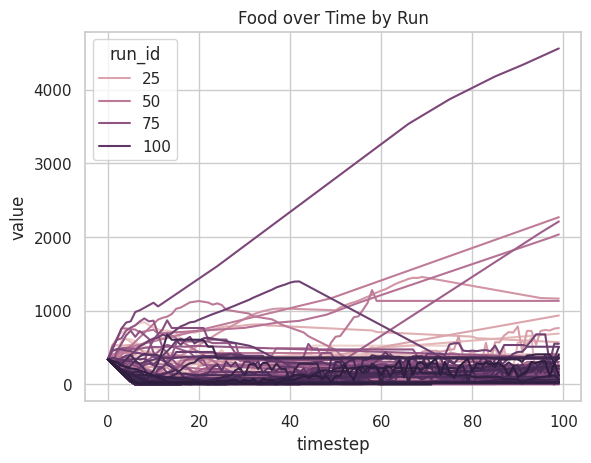

In [7]:

sns.lineplot(
    data=df_long[(df_long['metric_category'] == 'resources') & 
                 (df_long['metric_name'] == 'food')],
    x='timestep', y='value', hue='run_id'
)
plt.title('Food over Time by Run')
plt.show()

/tmp/ipykernel_59525/3949853471.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


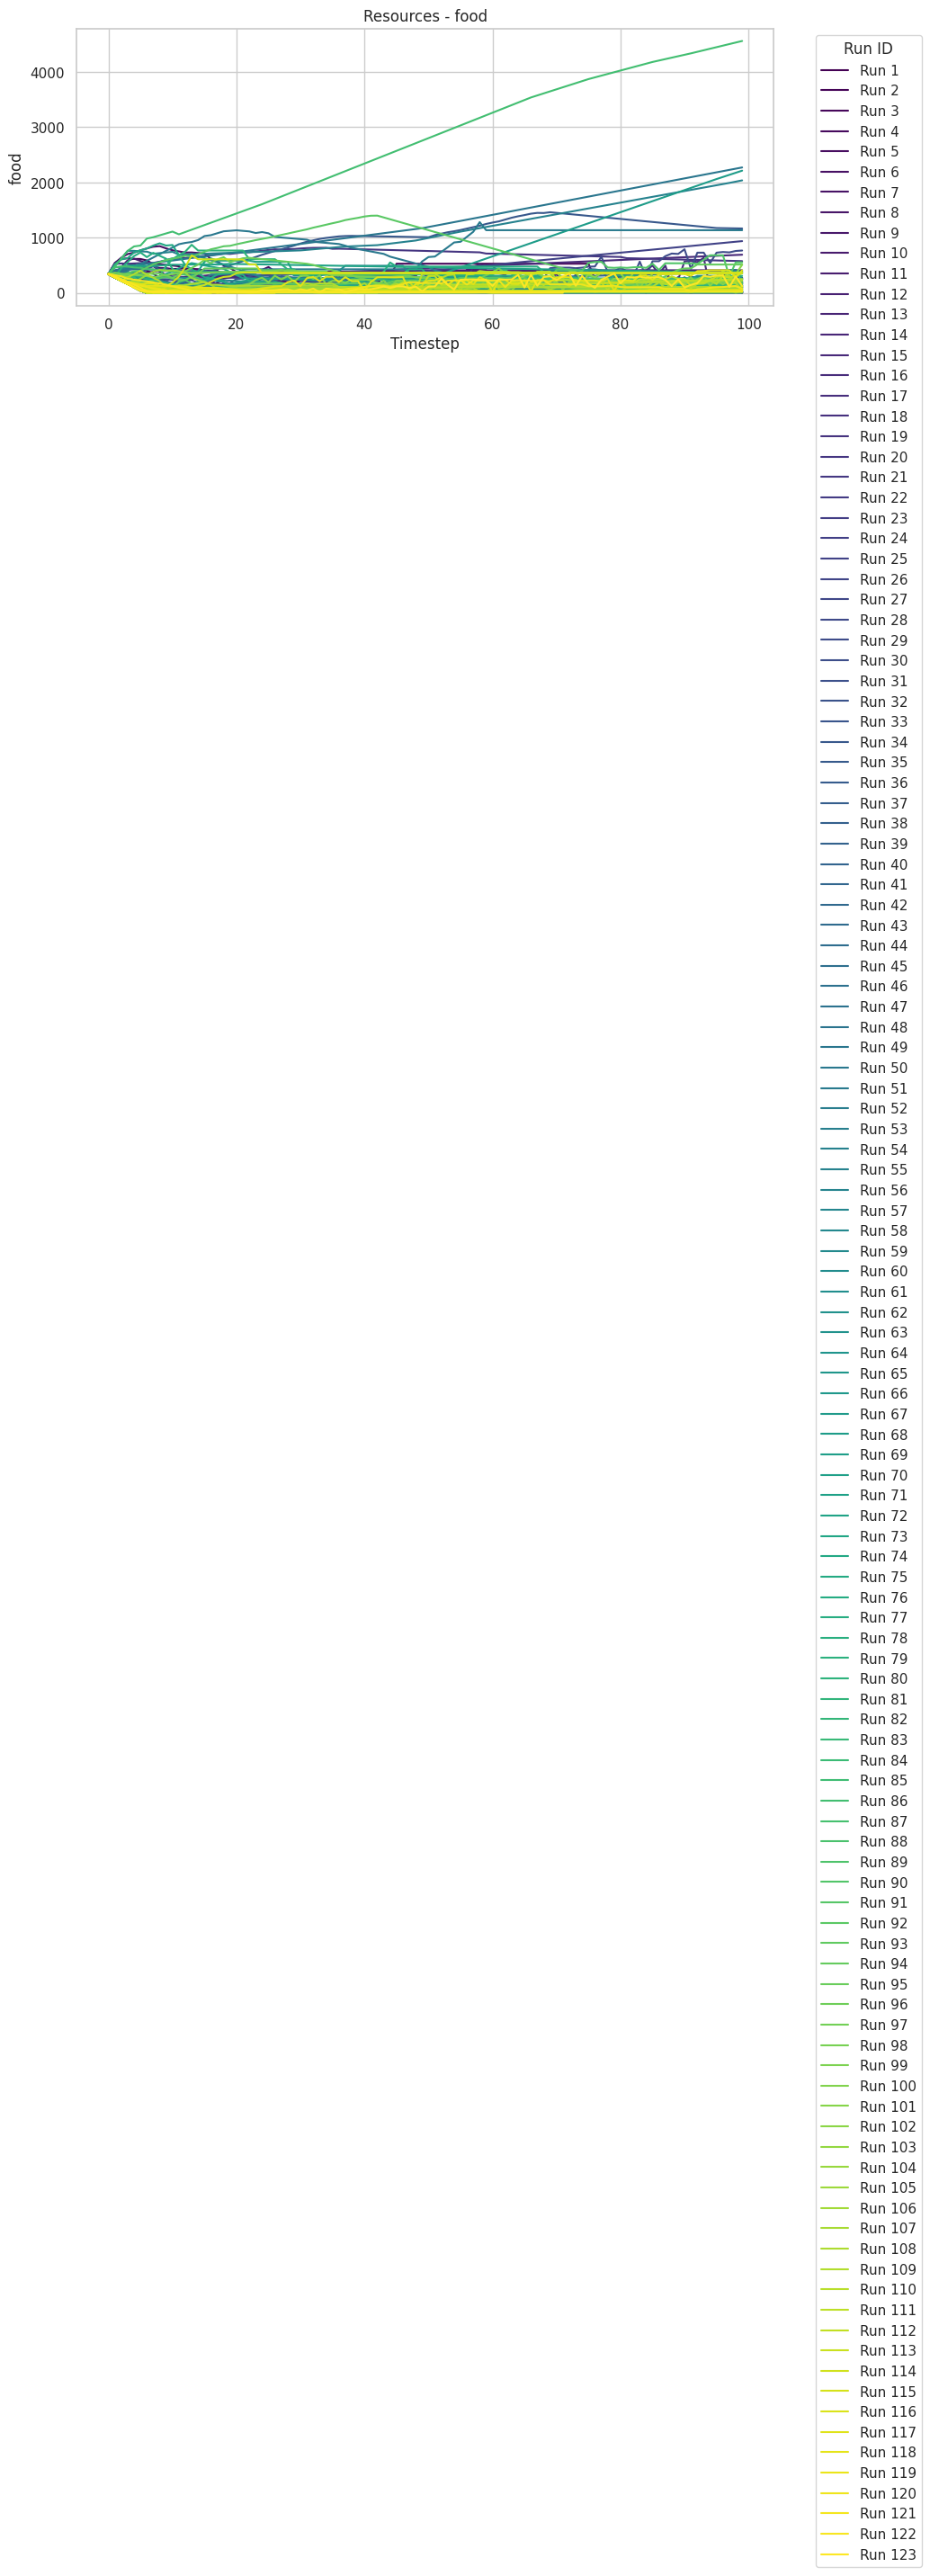

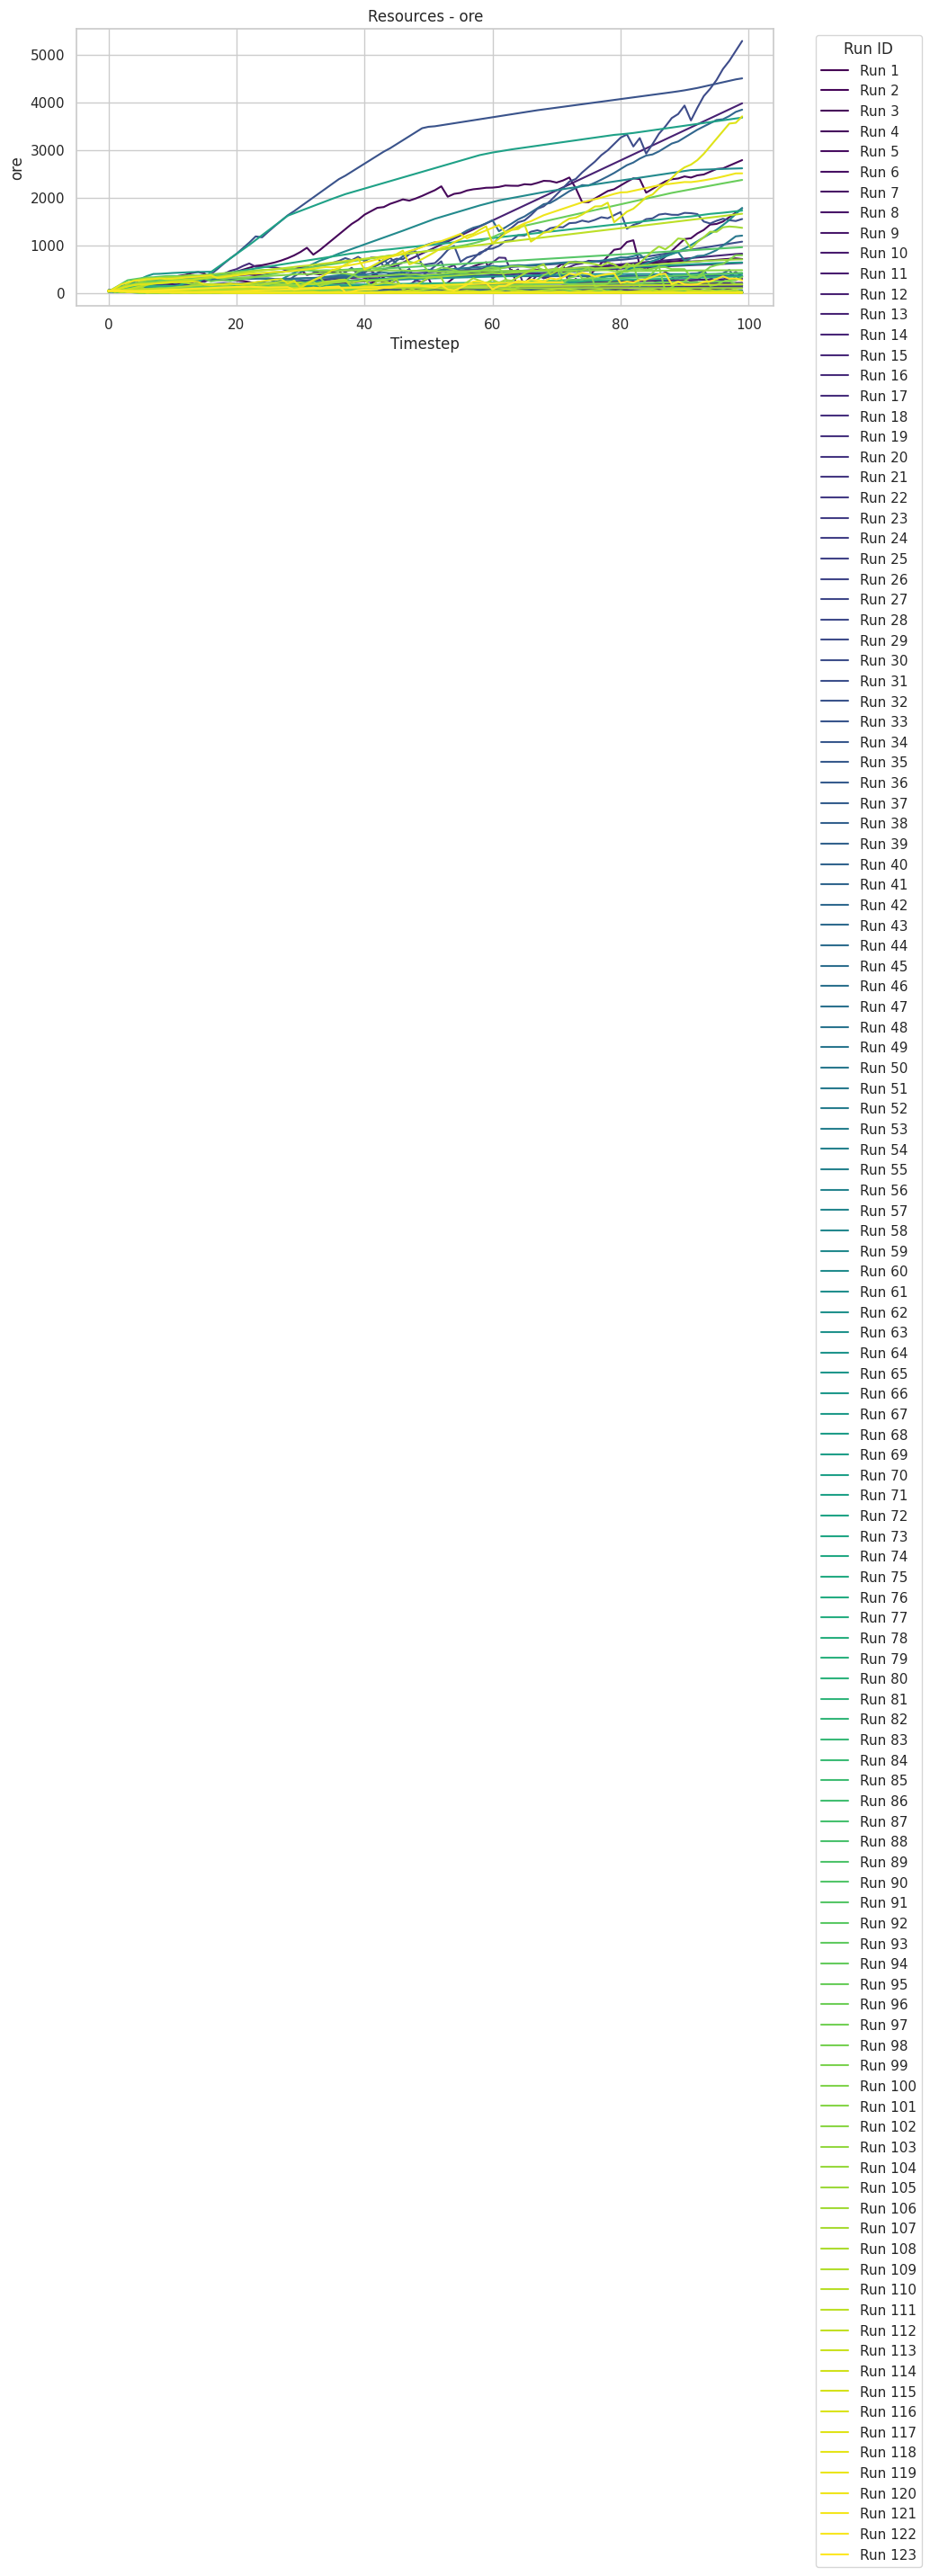

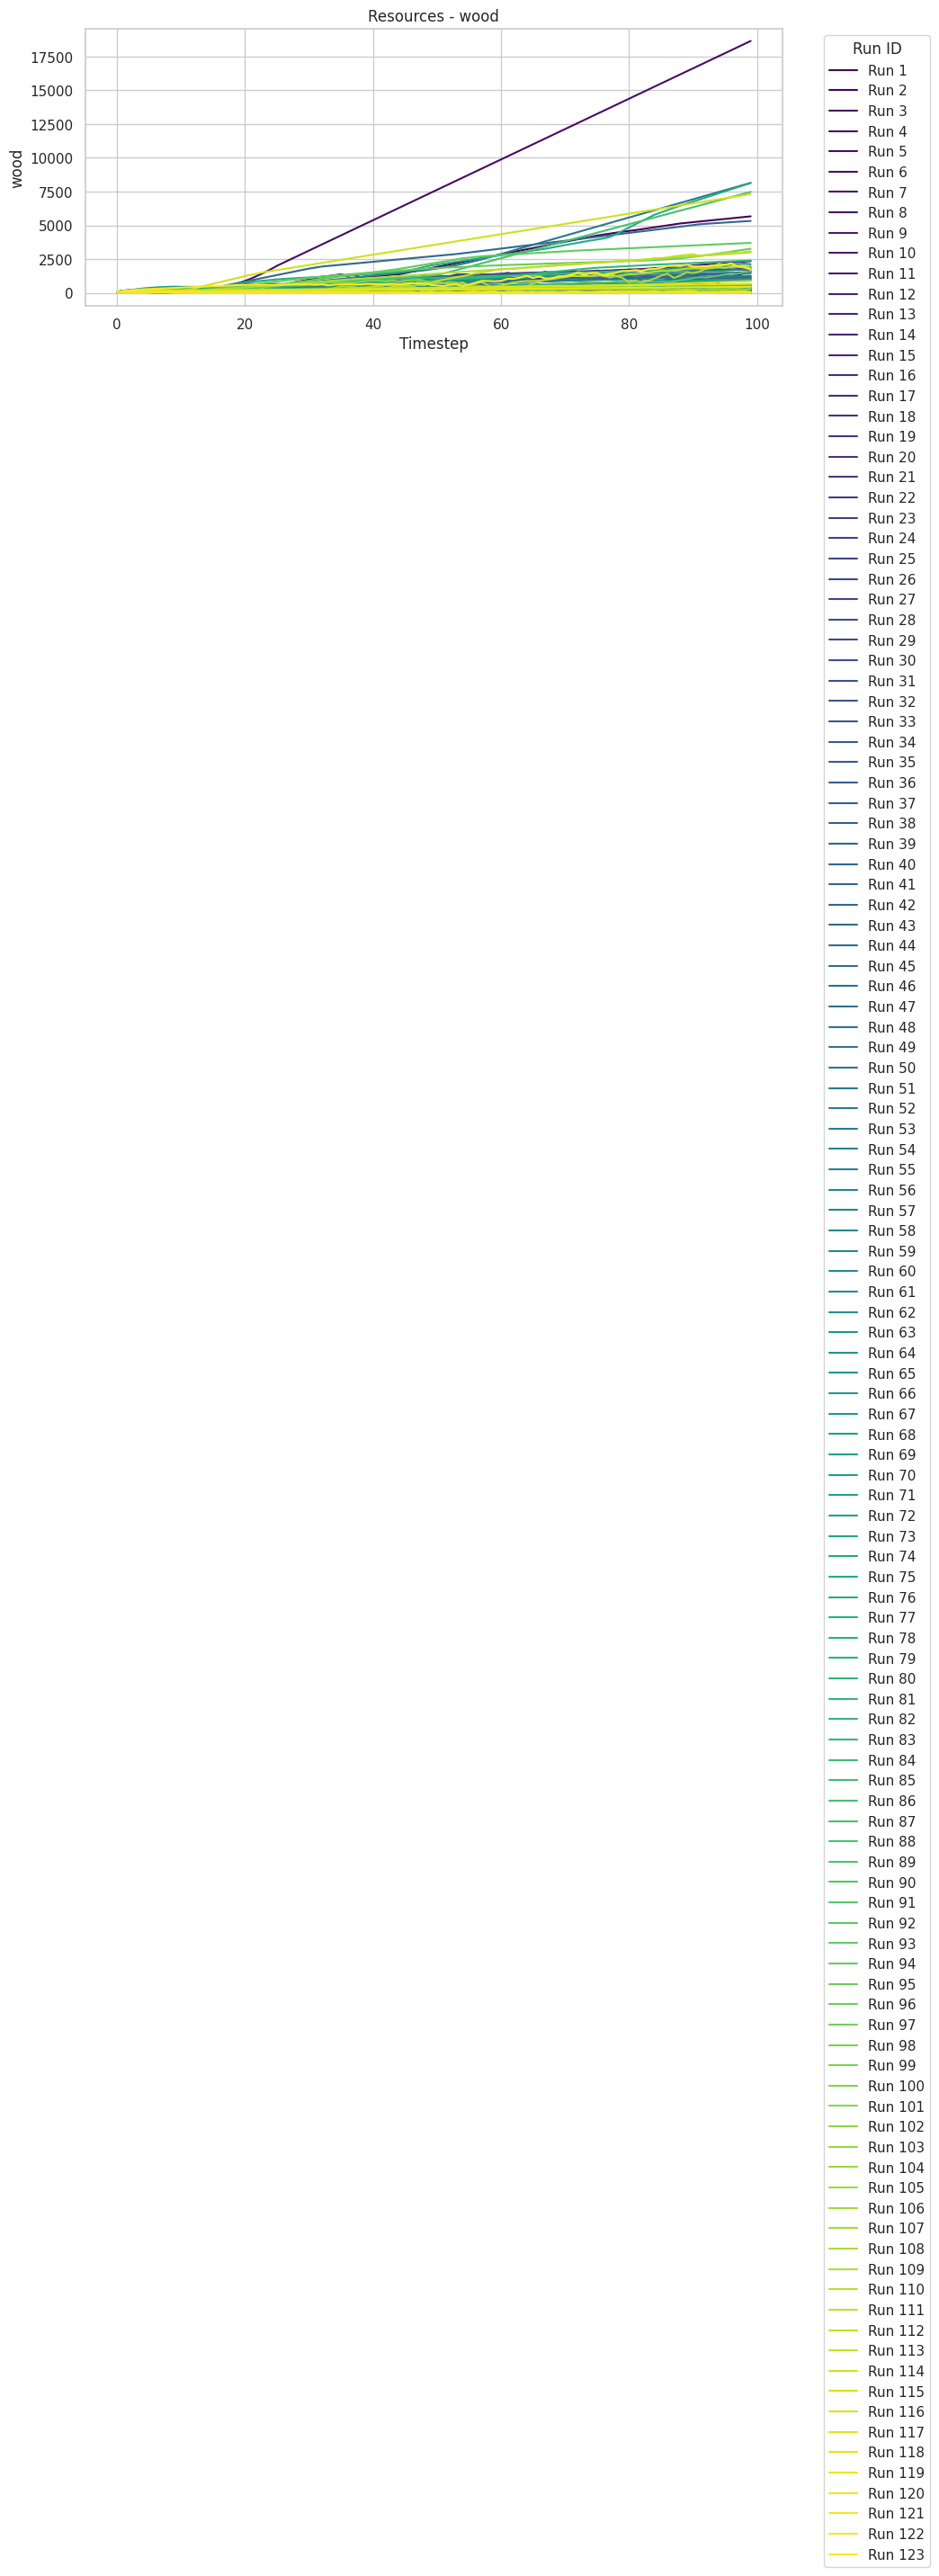

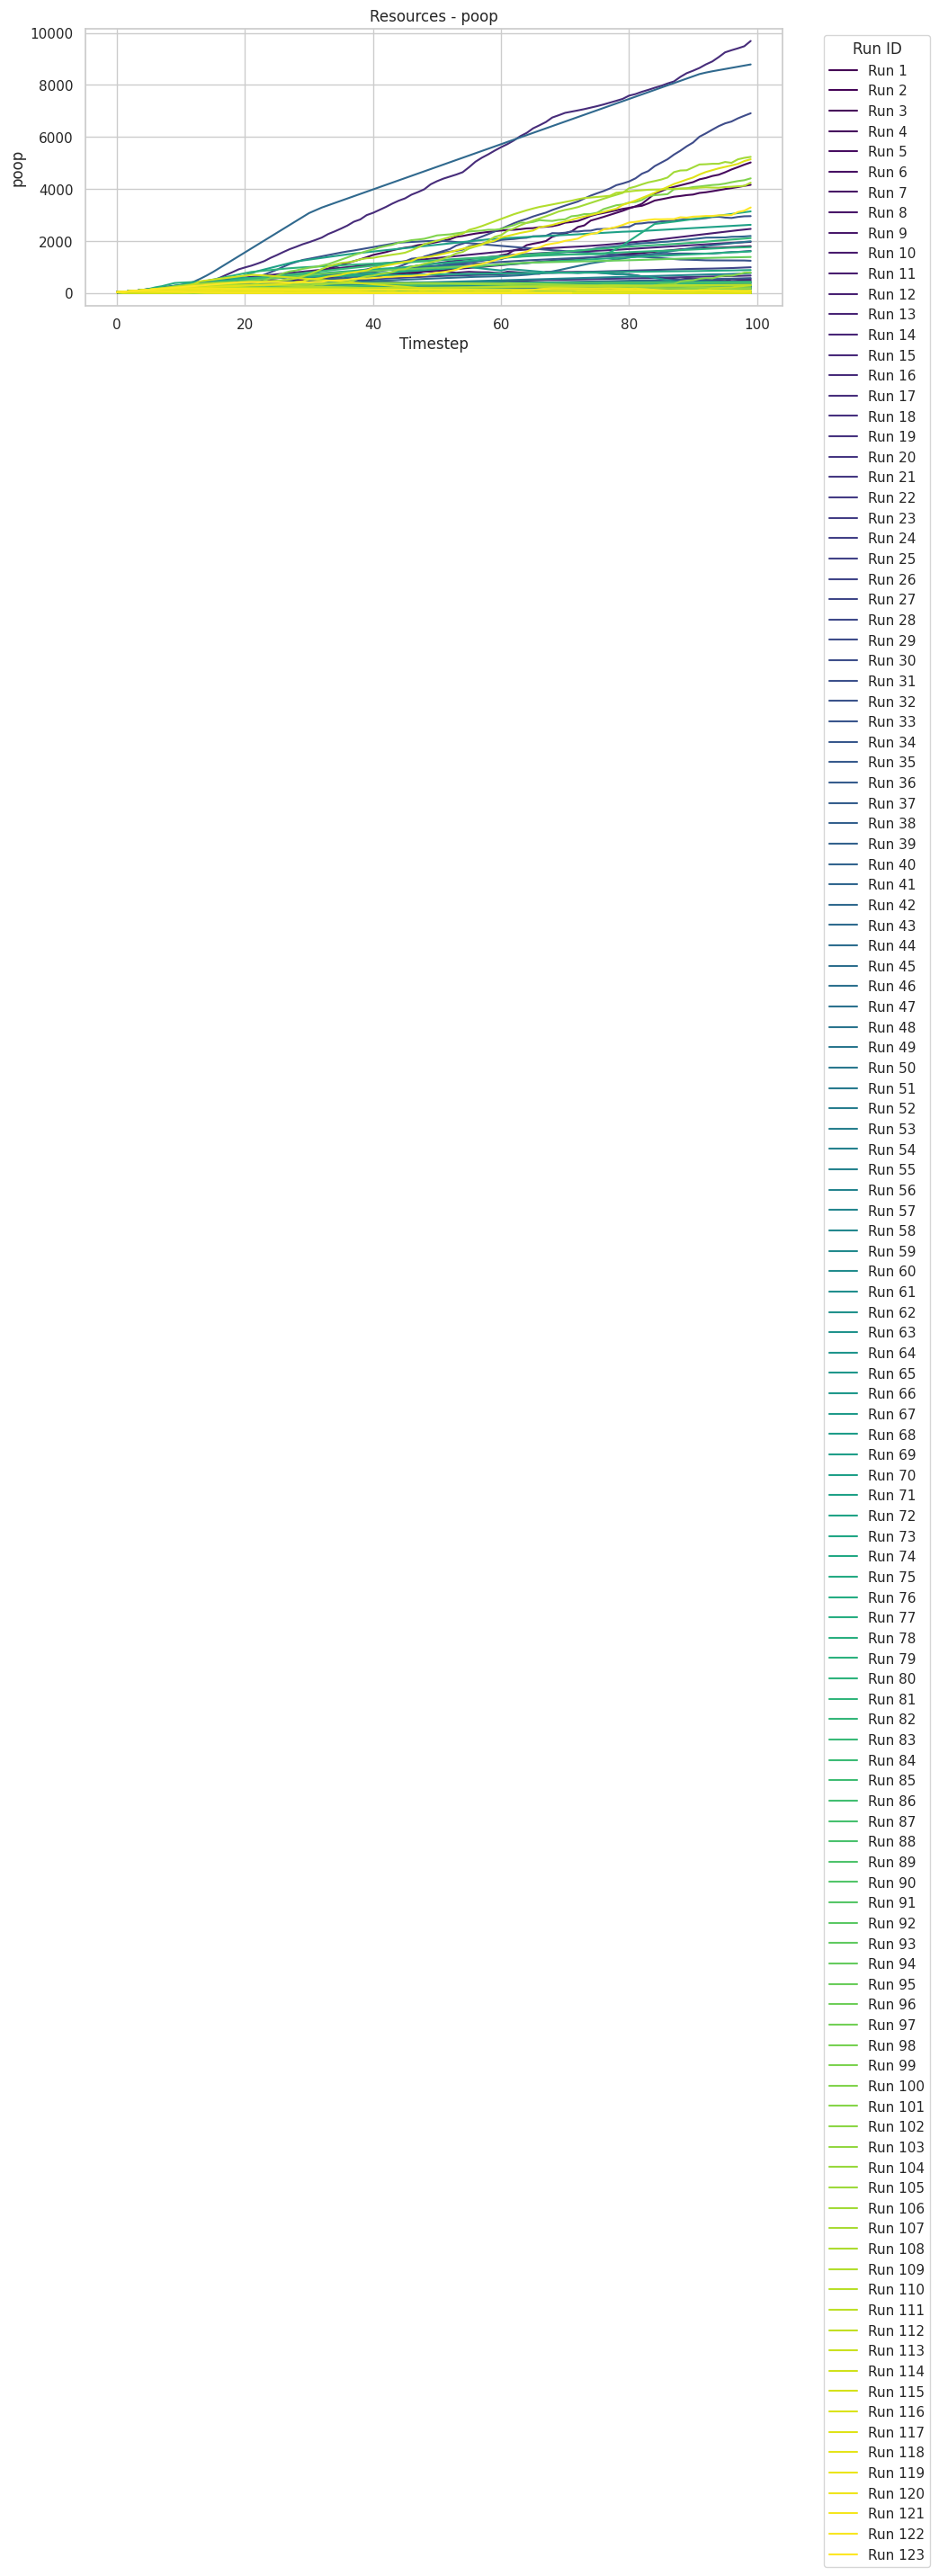

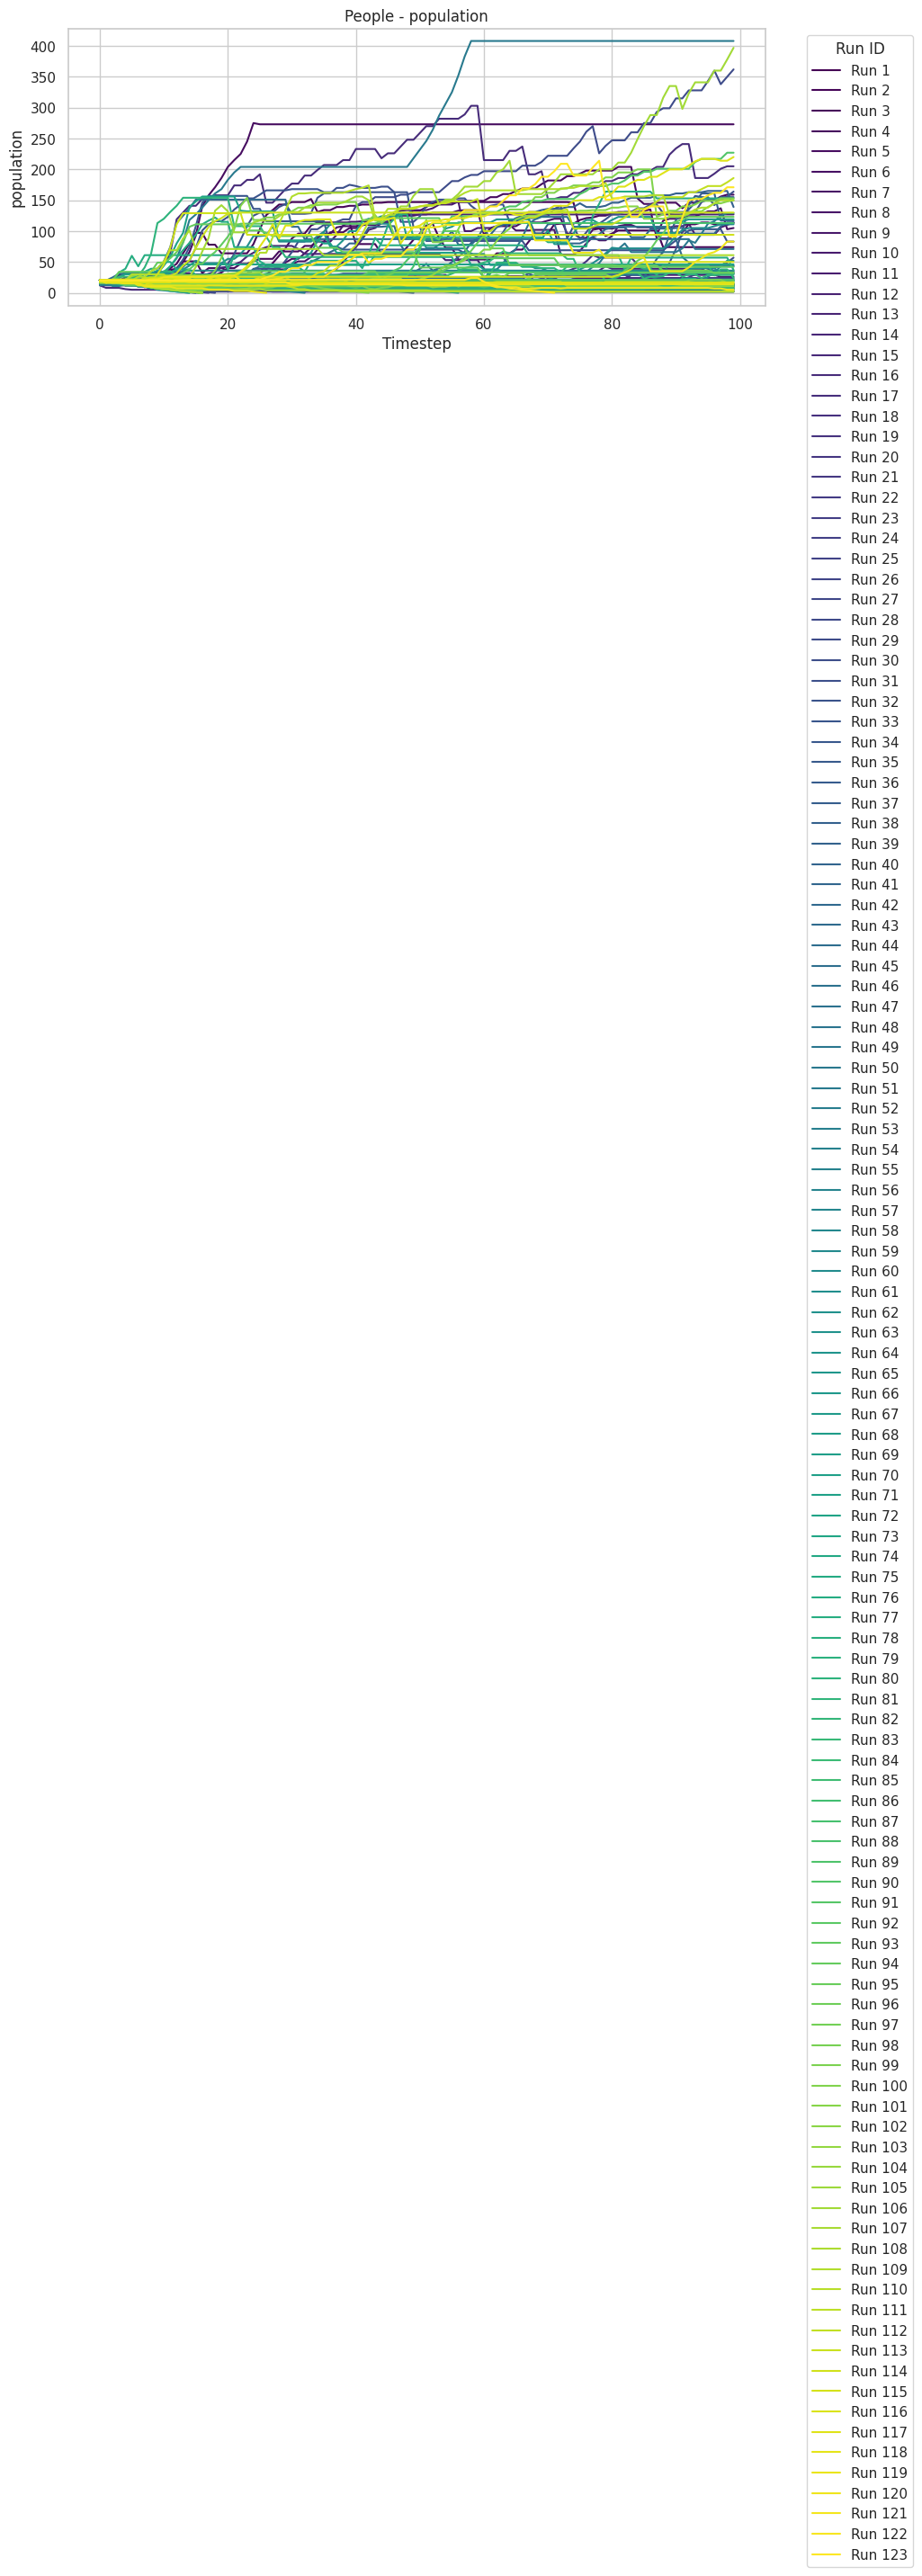

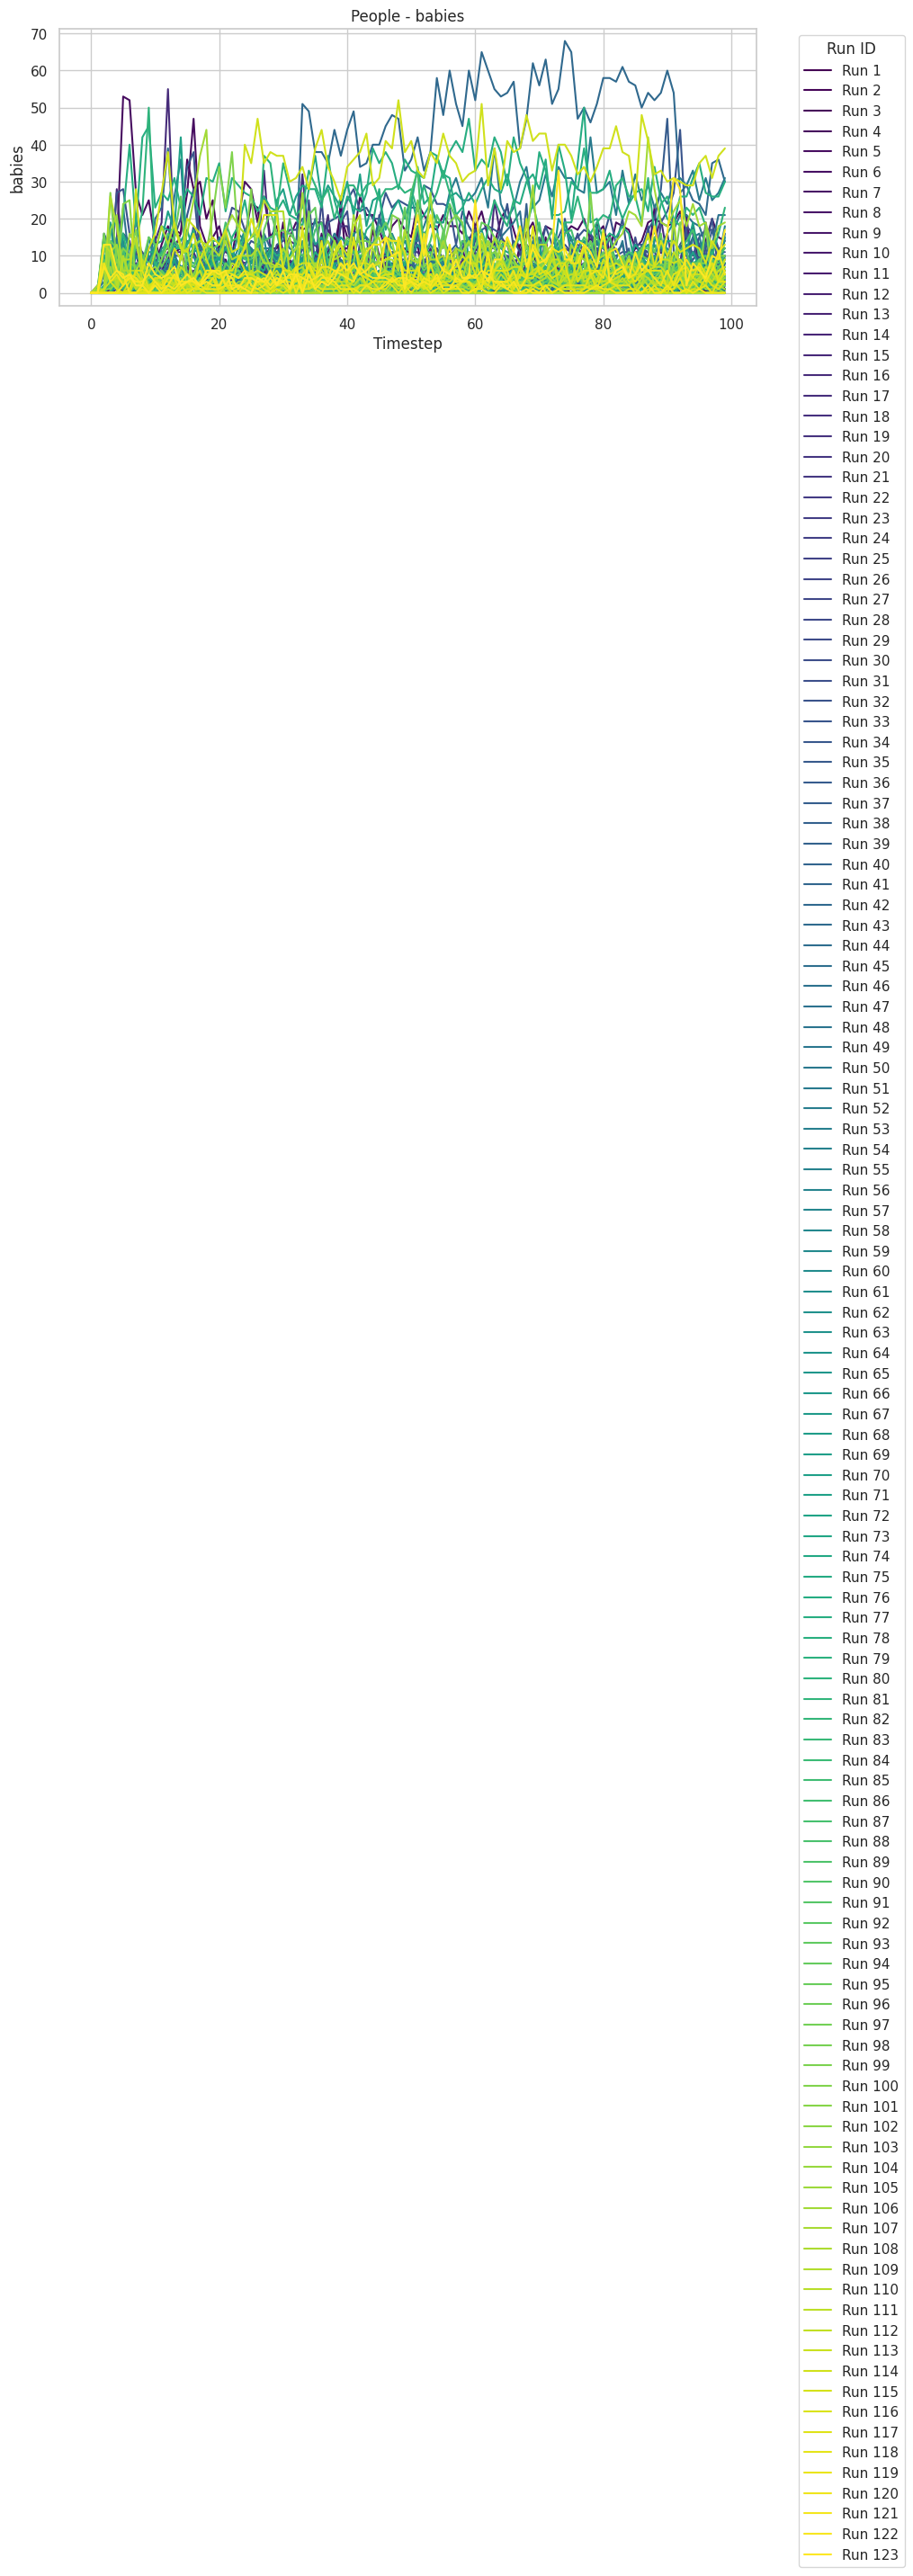

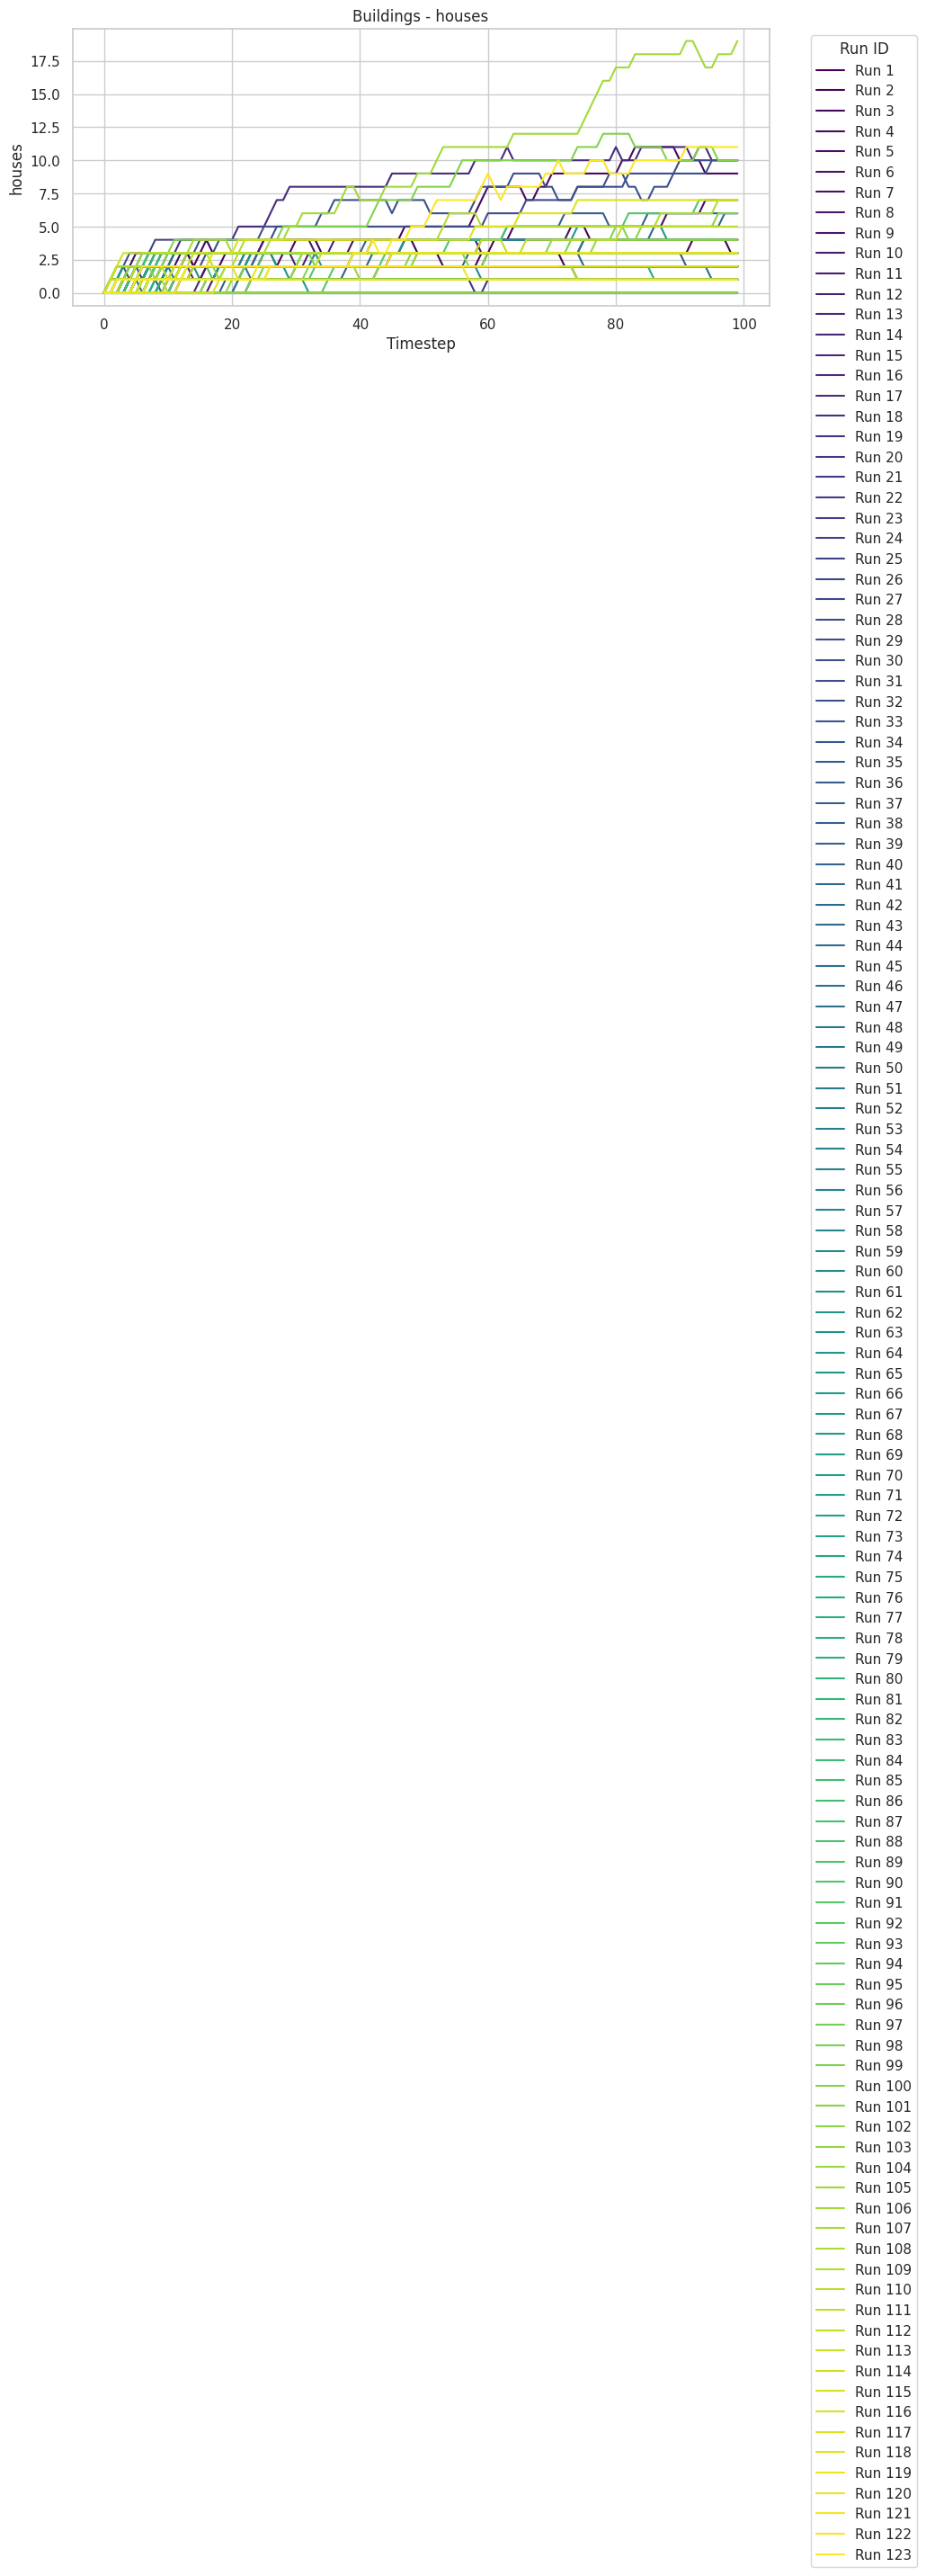

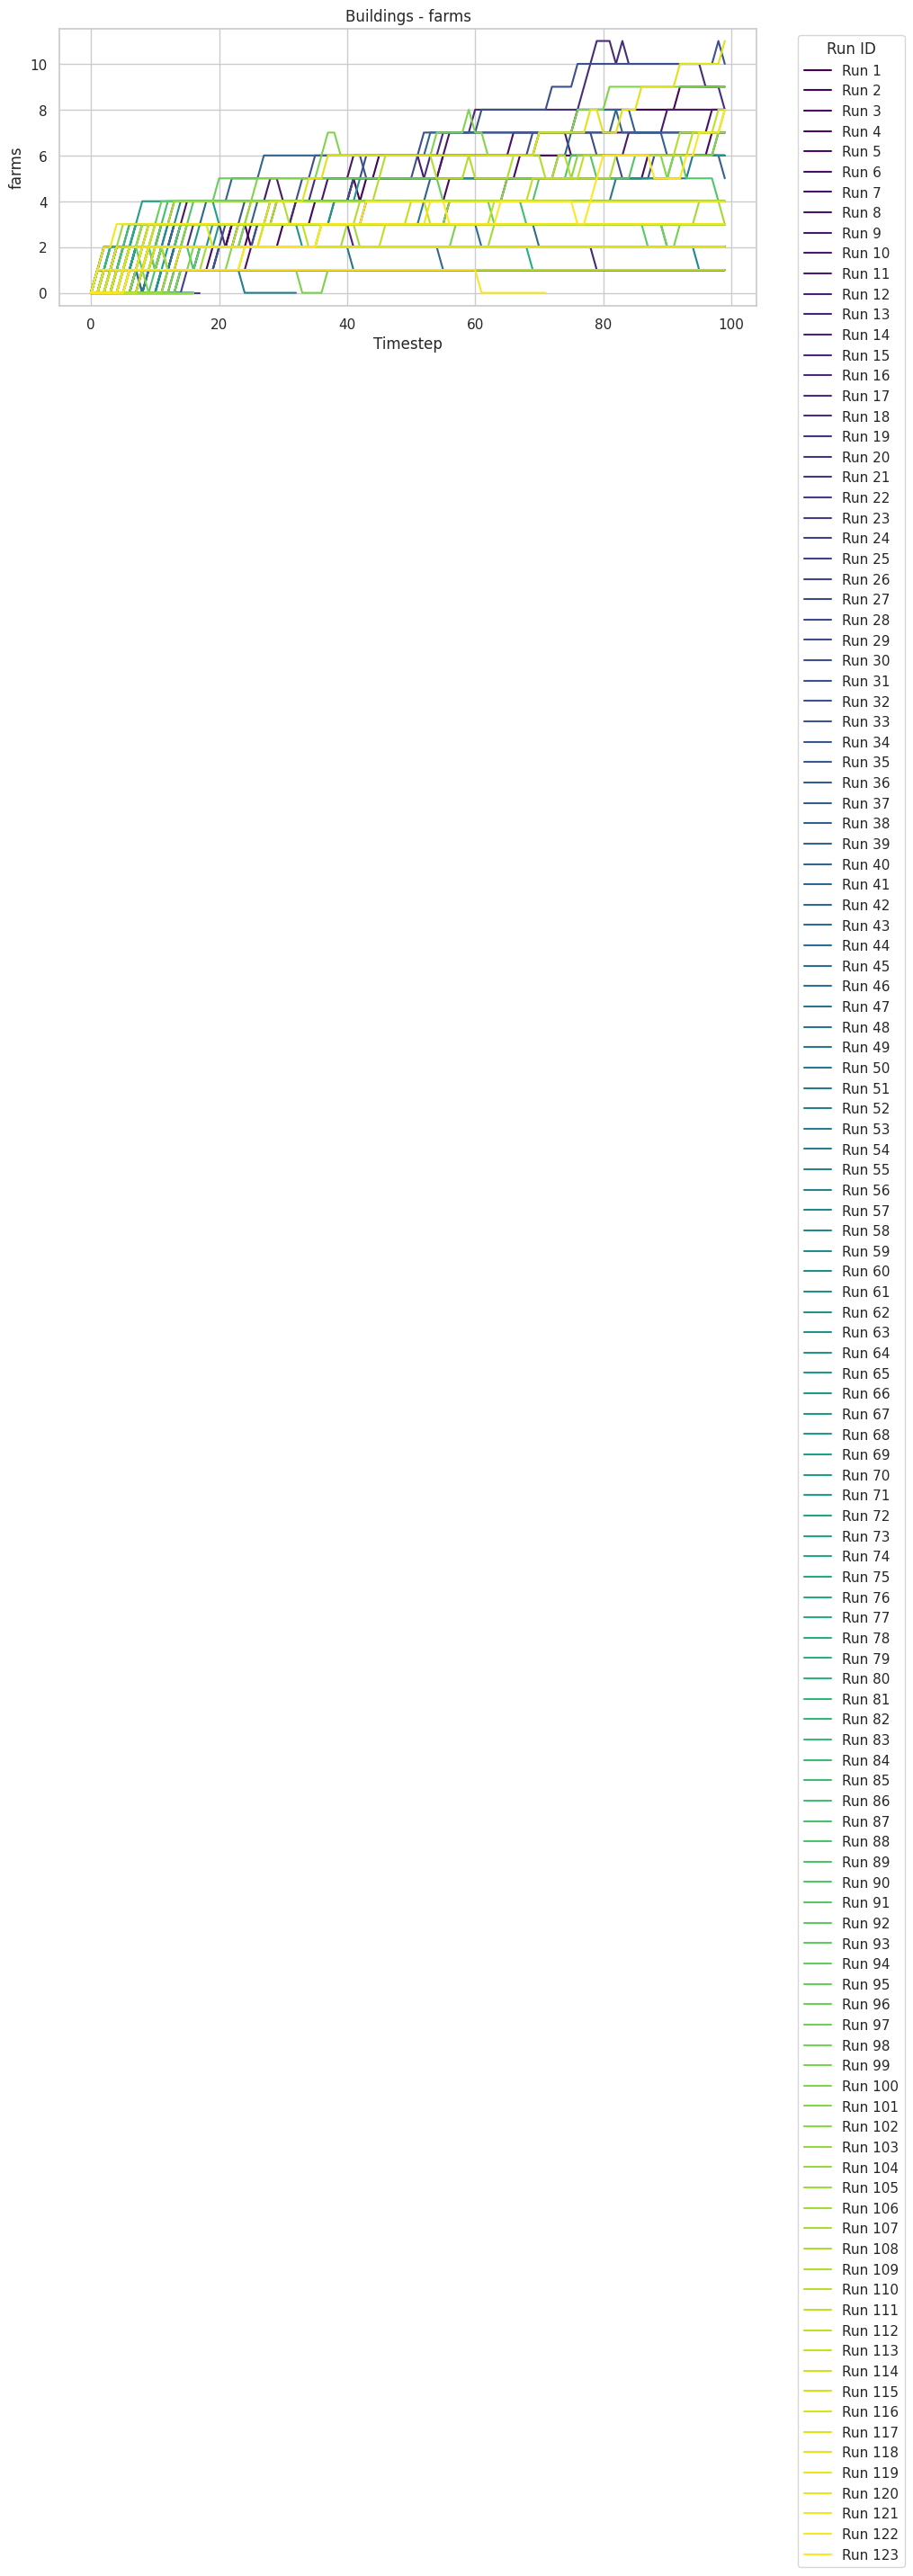

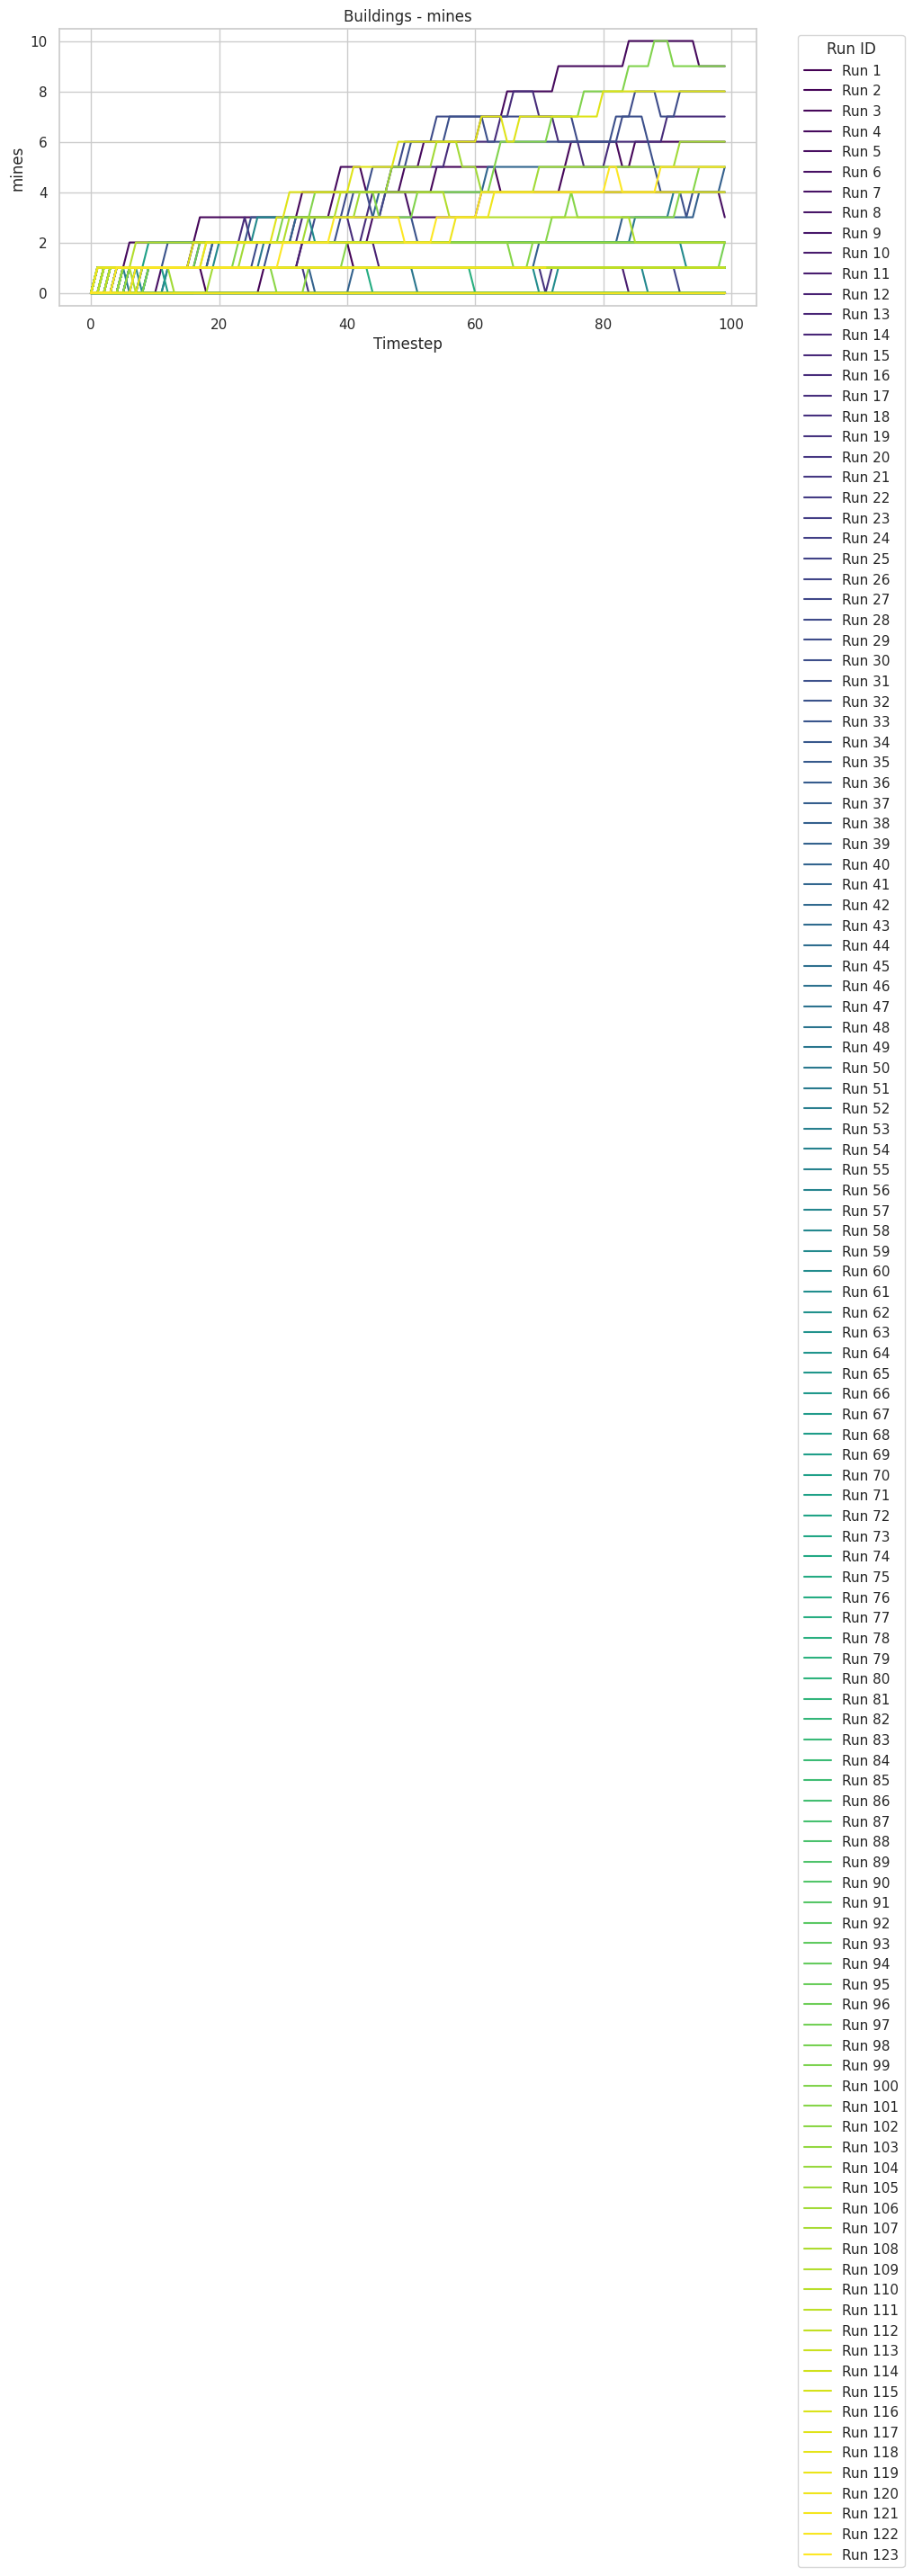

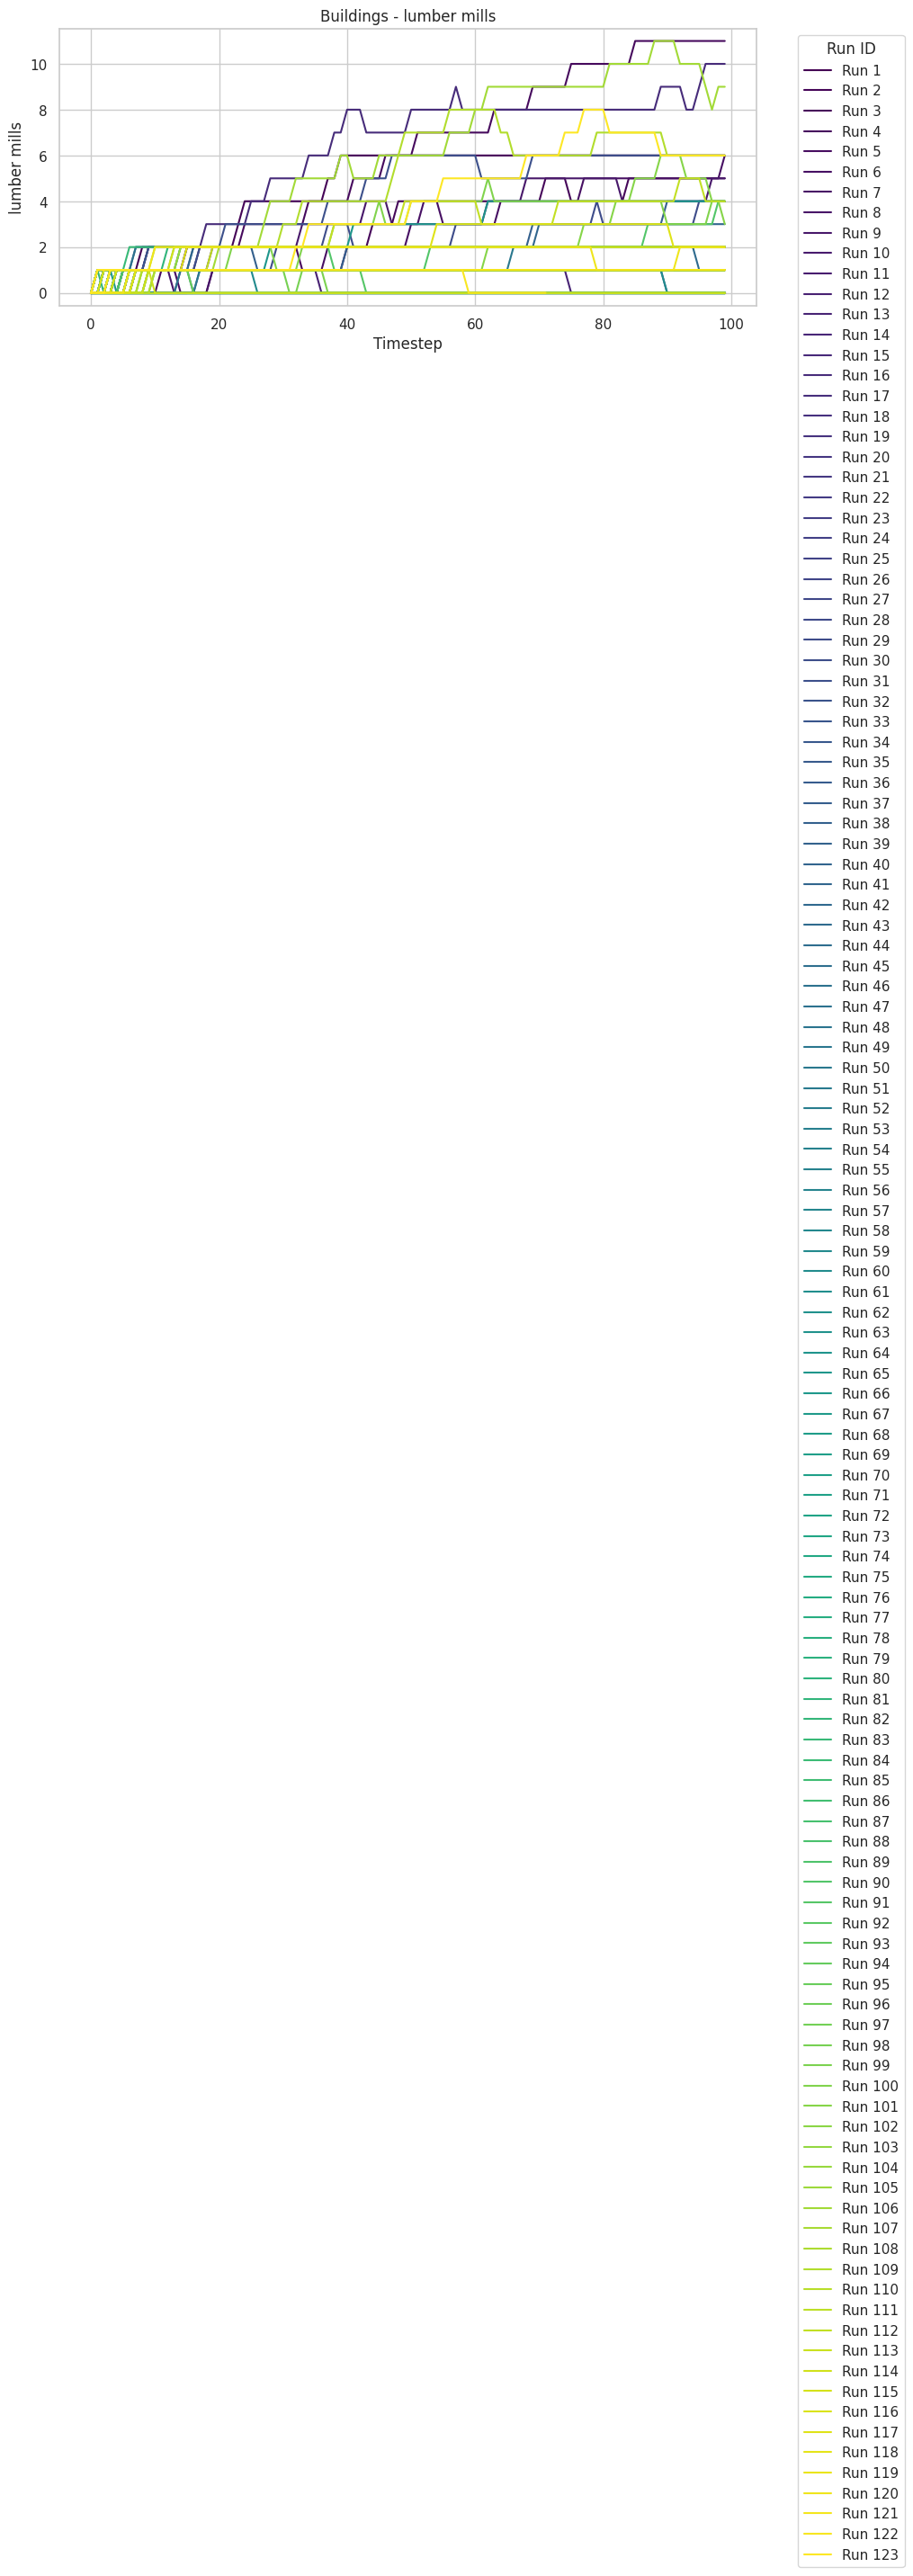

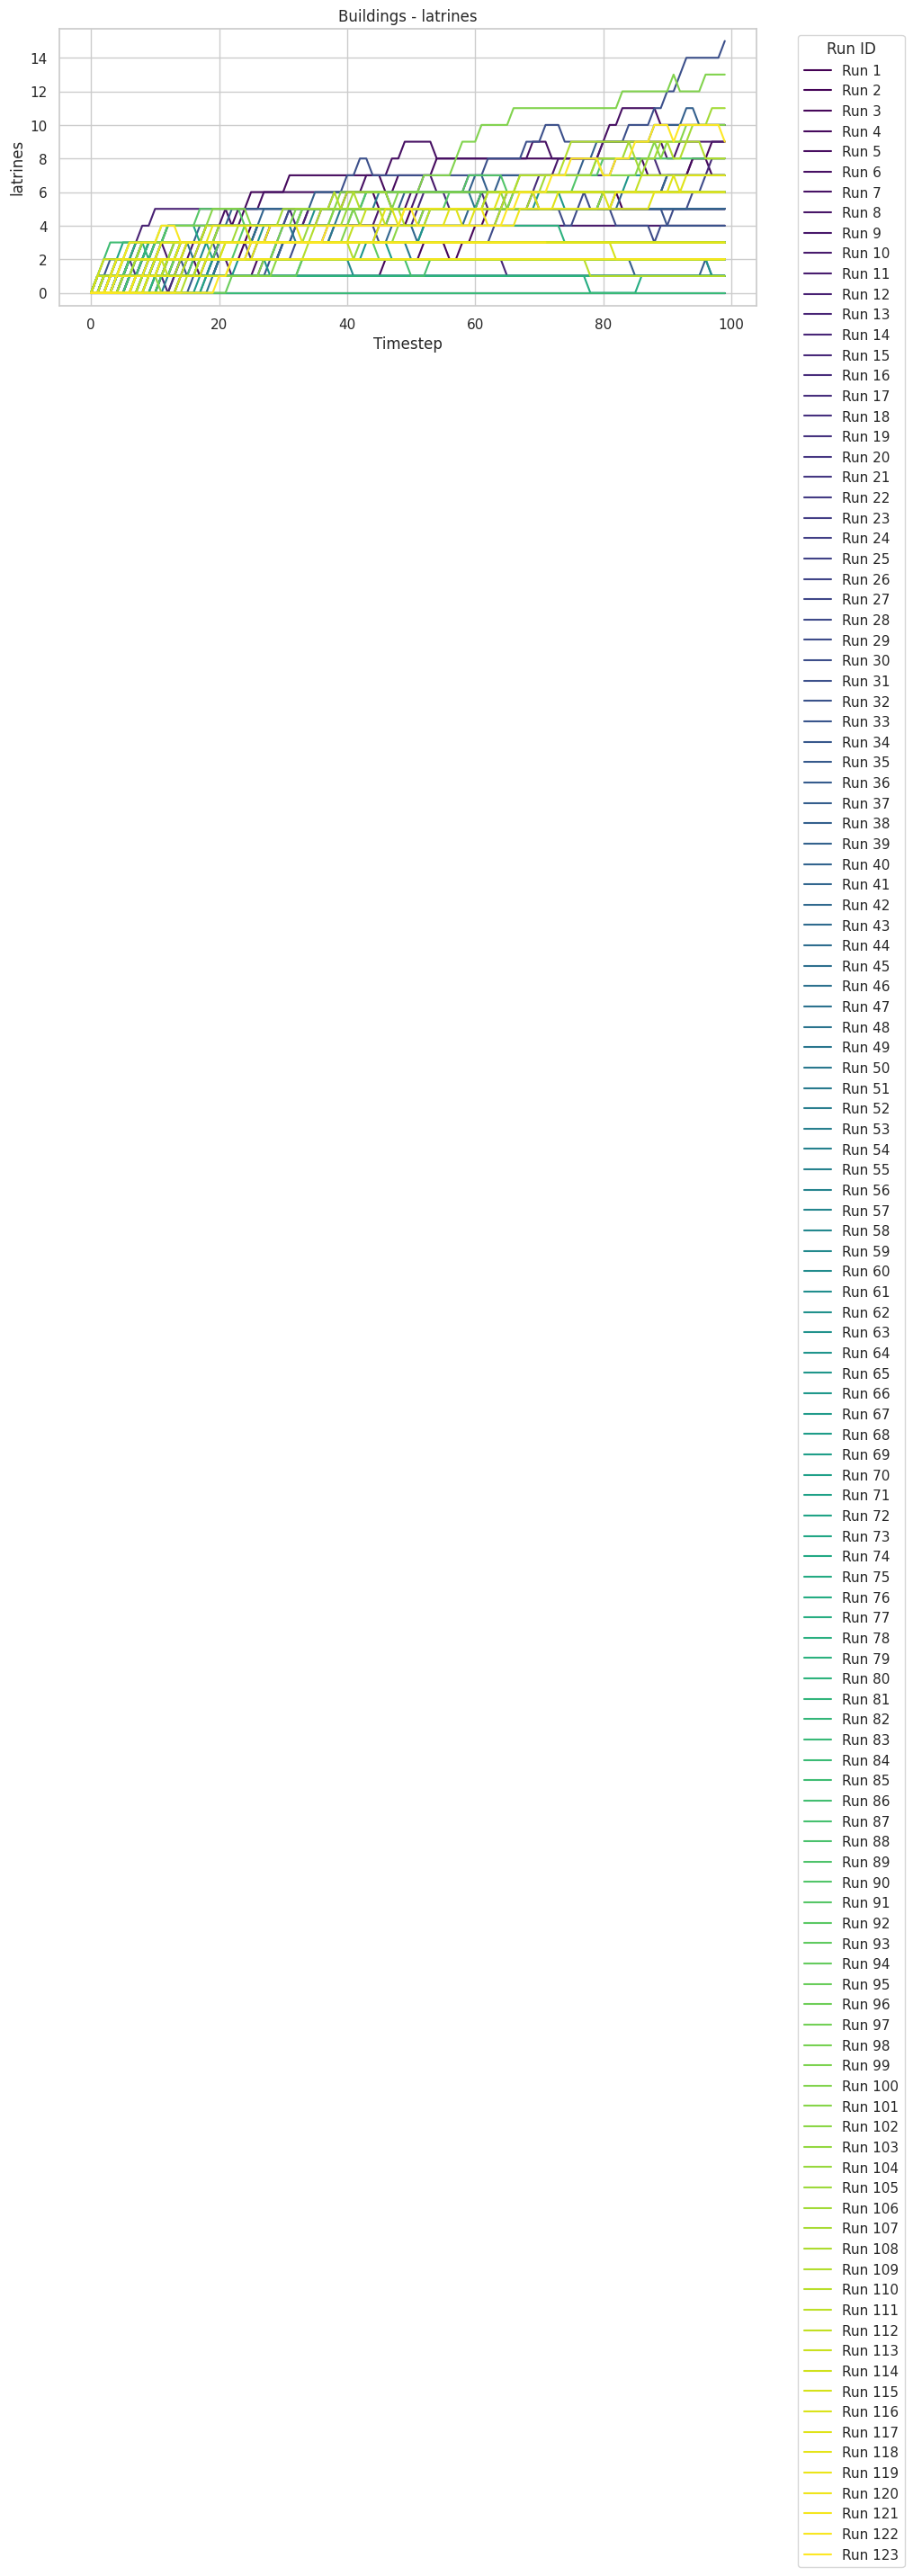

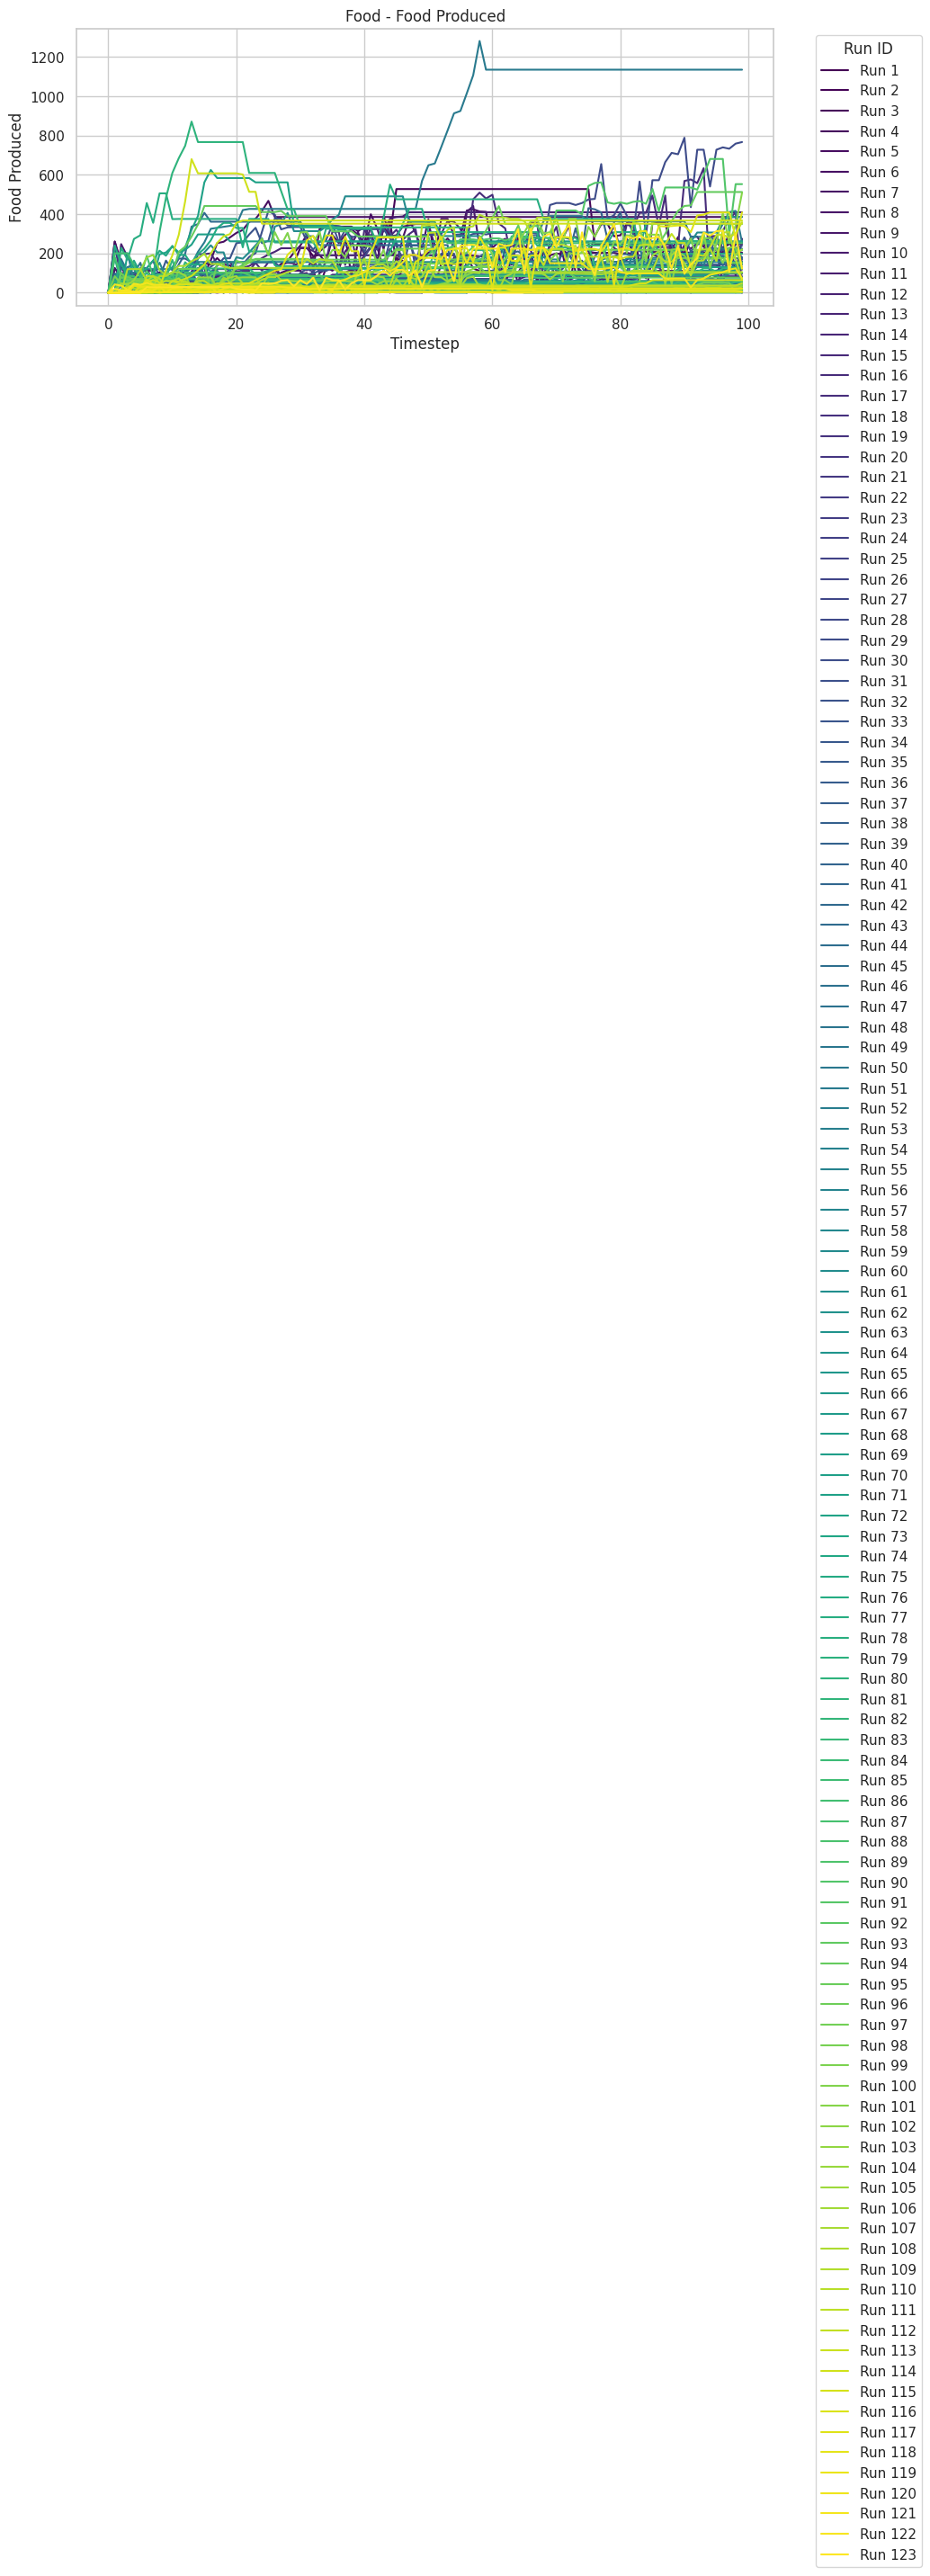

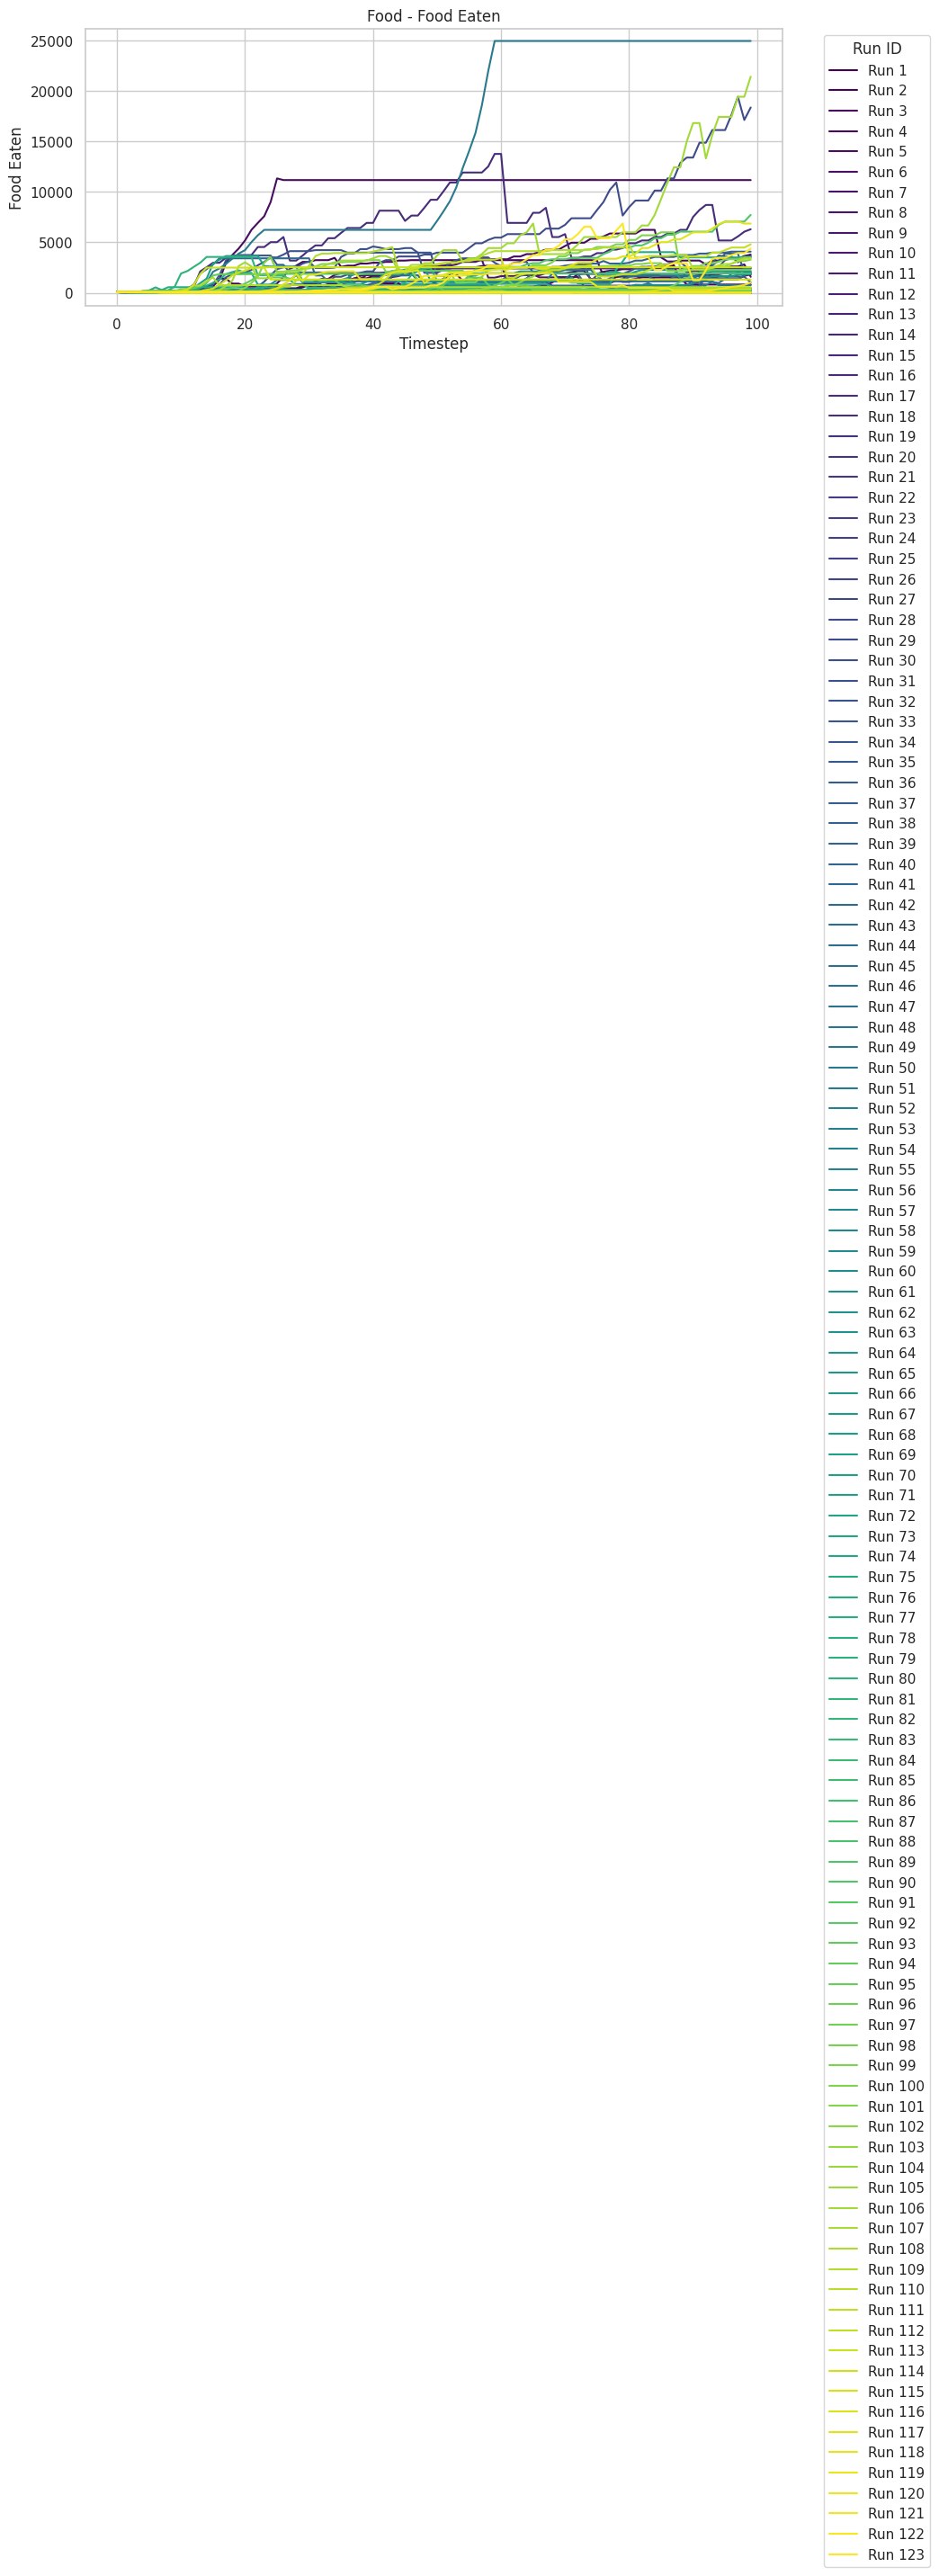

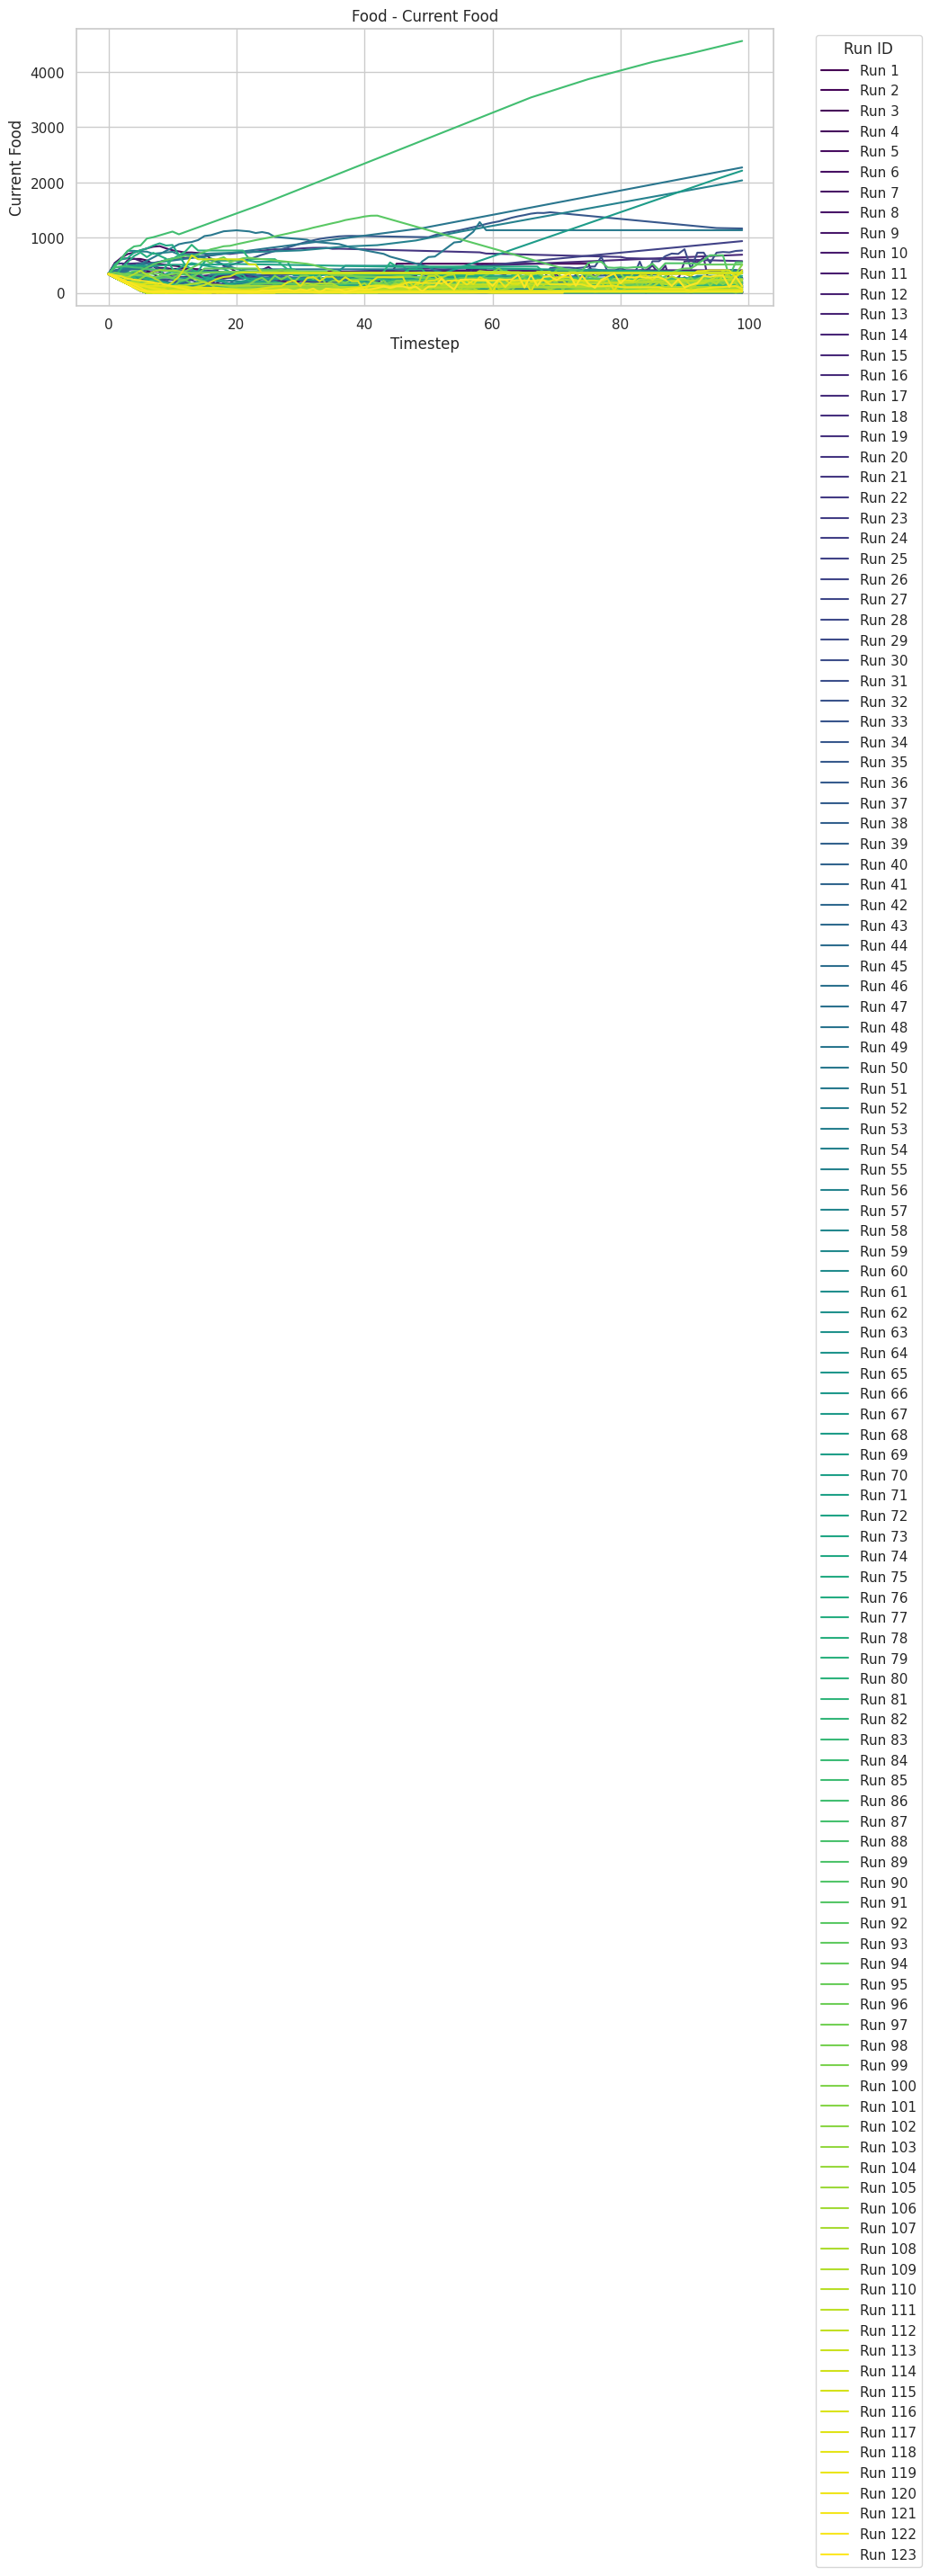

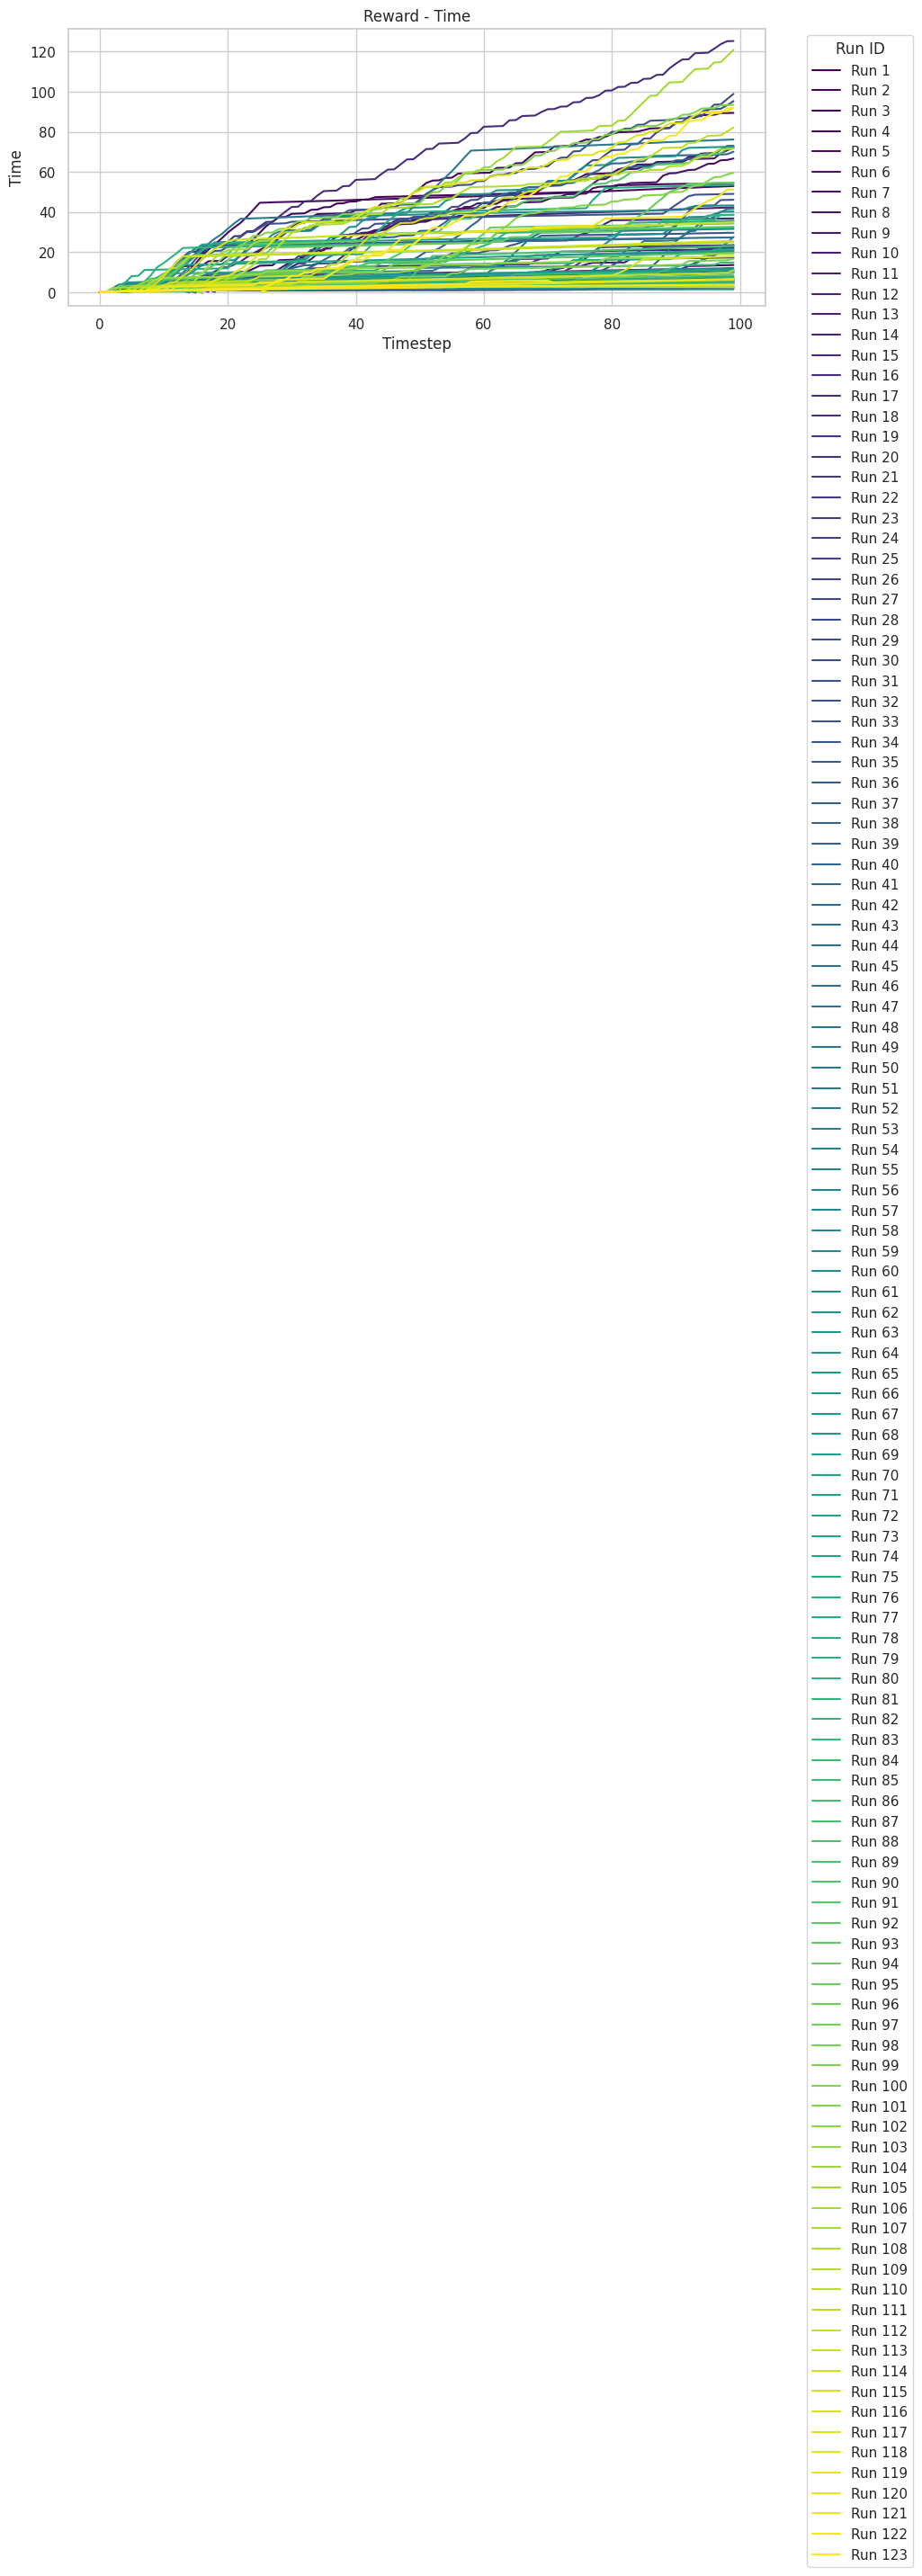

In [8]:
import matplotlib.cm as cm
import numpy as np

def plot_all_metrics(df):
    for category in df['metric_category'].unique():
        cat_df = df[df['metric_category'] == category]
        for metric in cat_df['metric_name'].unique():
            metric_df = cat_df[cat_df['metric_name'] == metric]

            # Create consistent, ordered color mapping
            run_ids = sorted(metric_df['run_id'].unique())
            num_runs = len(run_ids)
            colors = cm.viridis(np.linspace(0, 1, num_runs))
            run_id_to_color = {rid: colors[i] for i, rid in enumerate(run_ids)}

            plt.figure(figsize=(10, 4))
            for rid in run_ids:
                run_data = metric_df[metric_df['run_id'] == rid]
                plt.plot(run_data['timestep'], run_data['value'], label=f'Run {rid}', color=run_id_to_color[rid])

            plt.title(f'{category.title()} - {metric}')
            plt.xlabel('Timestep')
            plt.ylabel(metric)
            plt.legend(title='Run ID', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

plot_all_metrics(df_long)


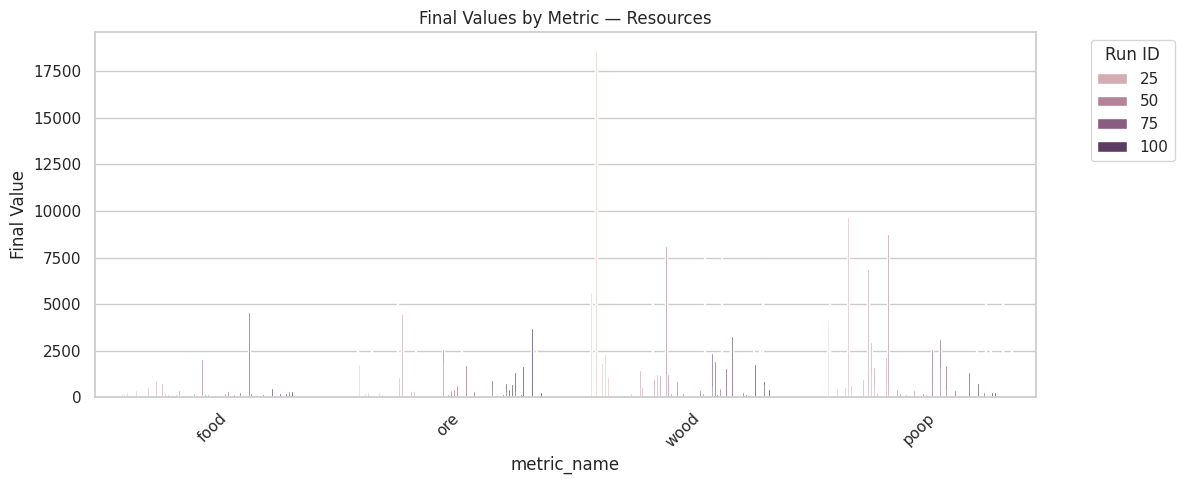

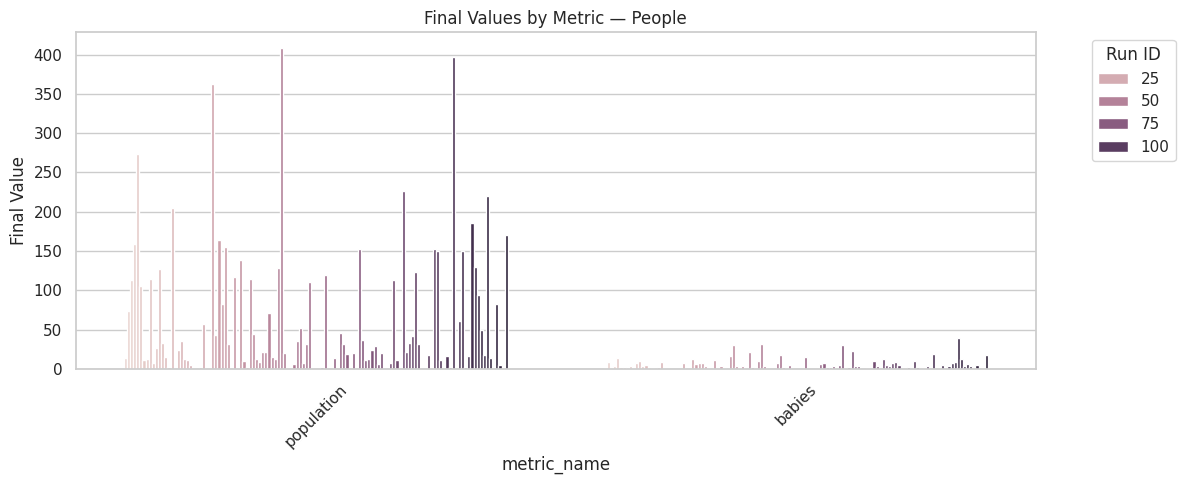

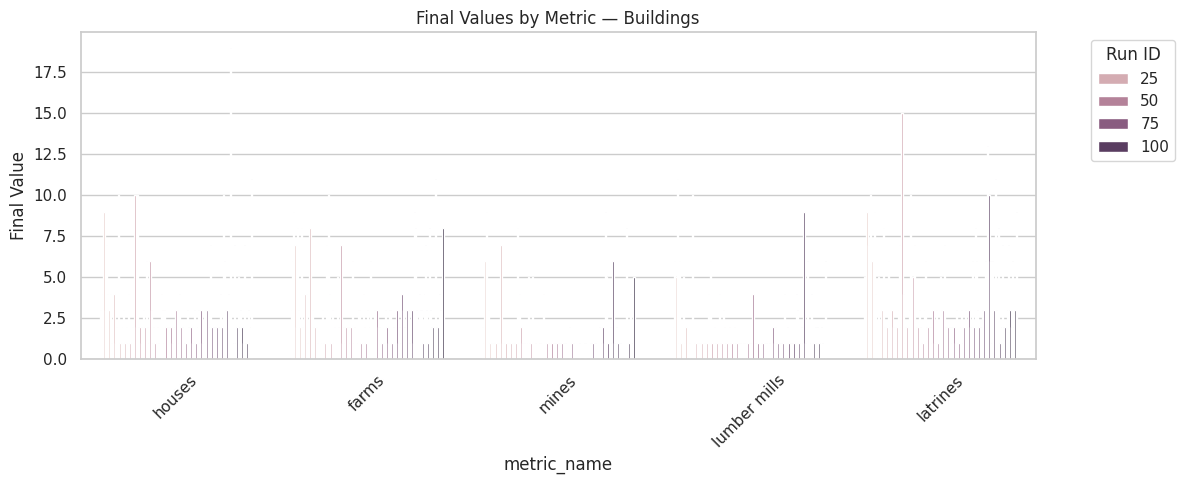

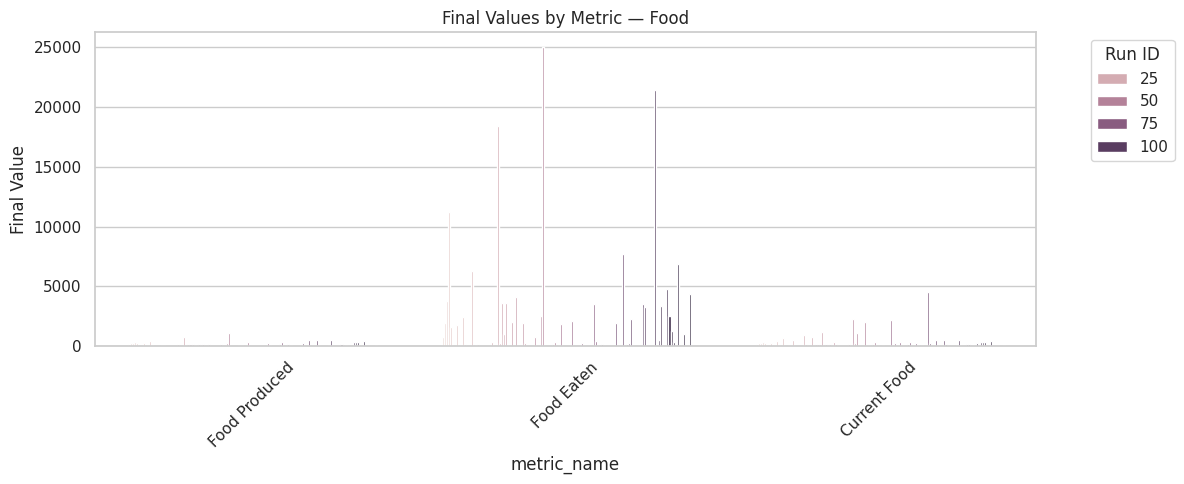

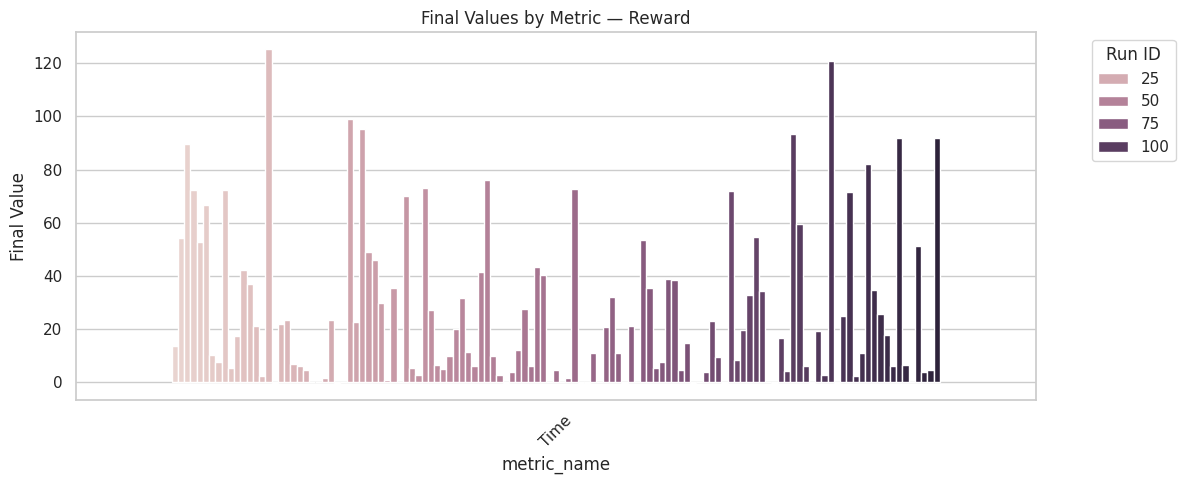

In [9]:
def plot_final_values(df):
    final_df = df.groupby(['run_id', 'metric_category', 'metric_name']).tail(1)

    for category in final_df['metric_category'].unique():
        cat_df = final_df[final_df['metric_category'] == category]
        plt.figure(figsize=(12, 5))
        sns.barplot(data=cat_df, x='metric_name', y='value', hue='run_id', dodge=True)
        plt.title(f'Final Values by Metric — {category.title()}')
        plt.ylabel('Final Value')
        plt.xticks(rotation=45)
        plt.legend(title='Run ID', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

plot_final_values(df_long)

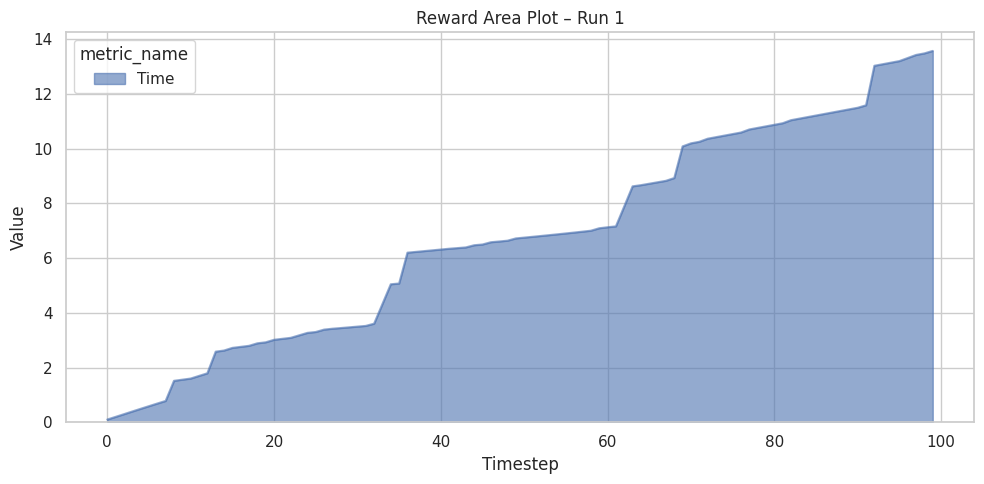

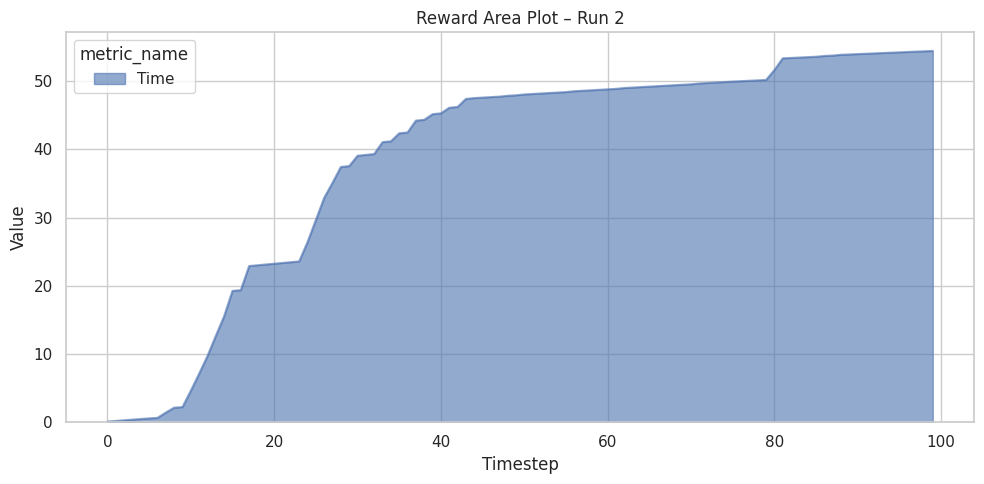

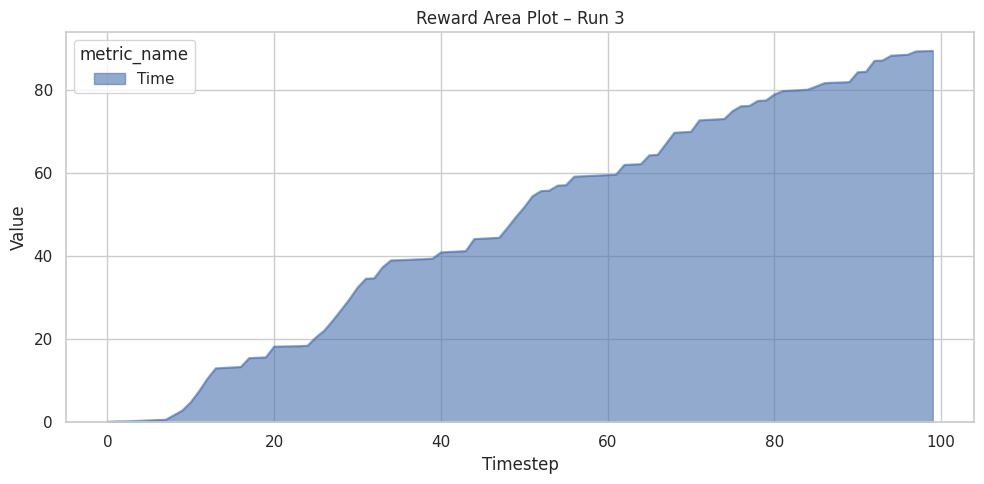

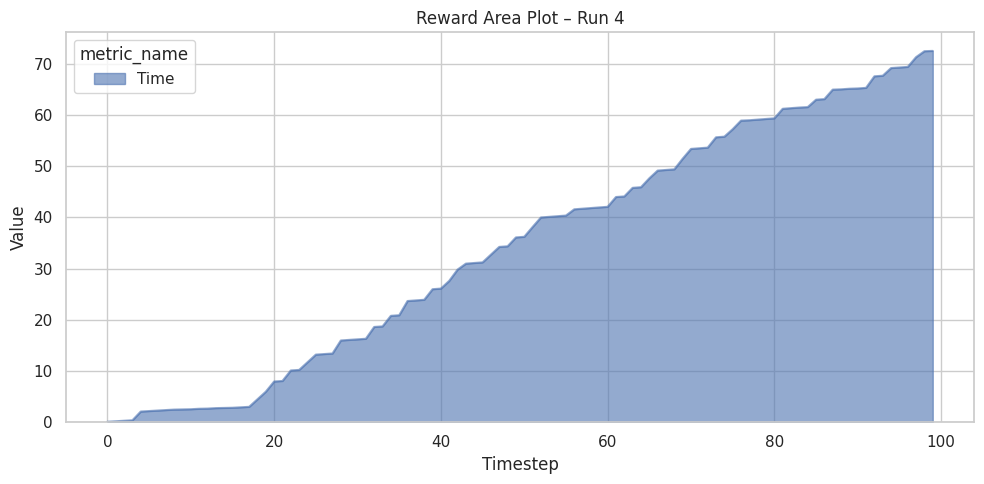

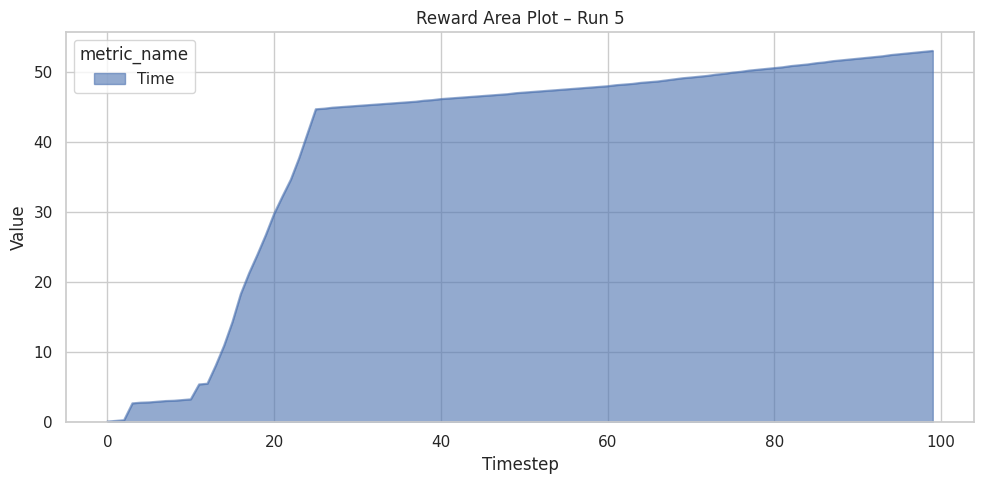

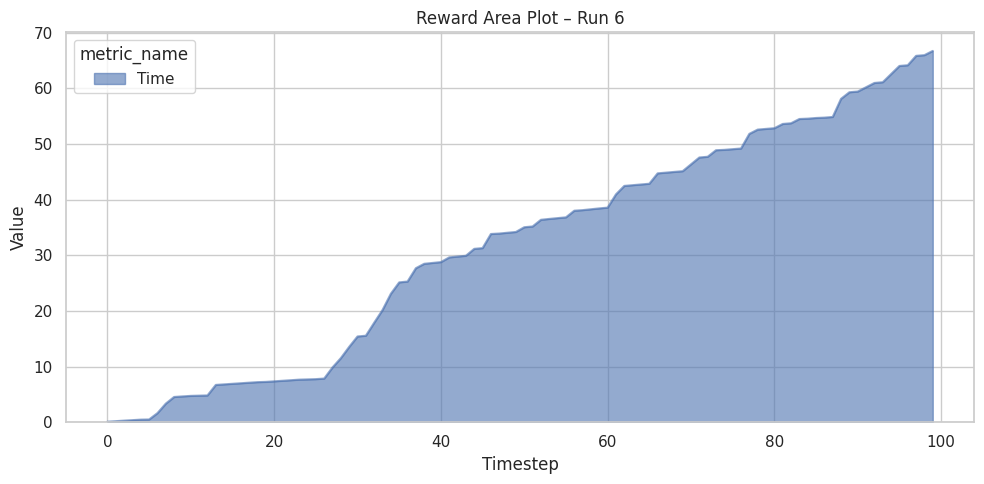

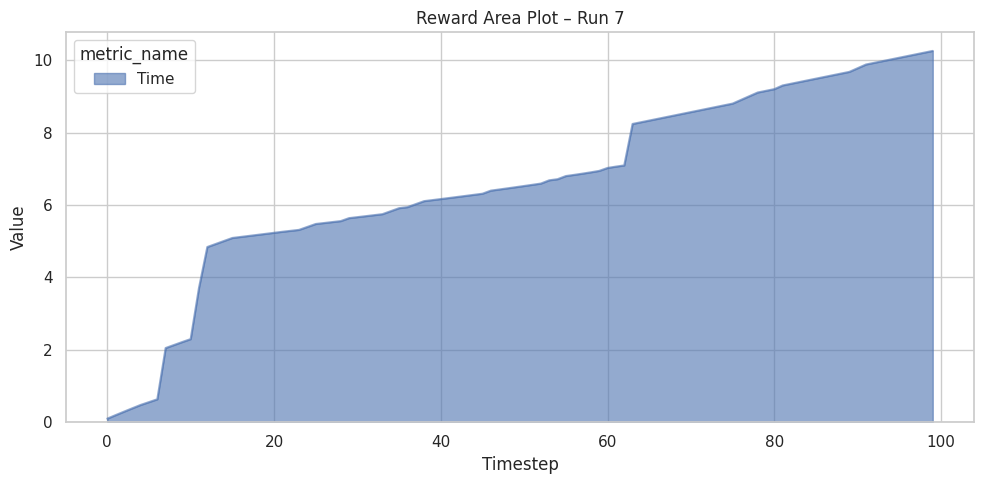

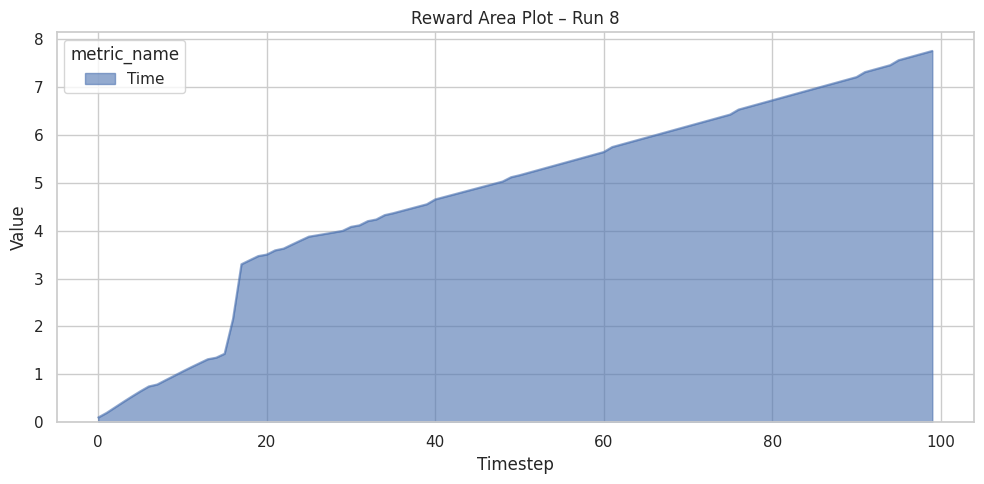

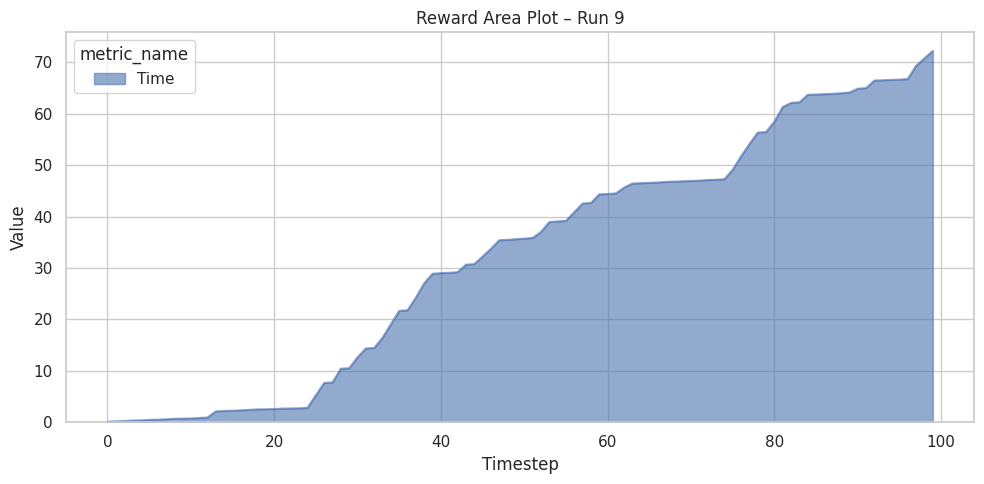

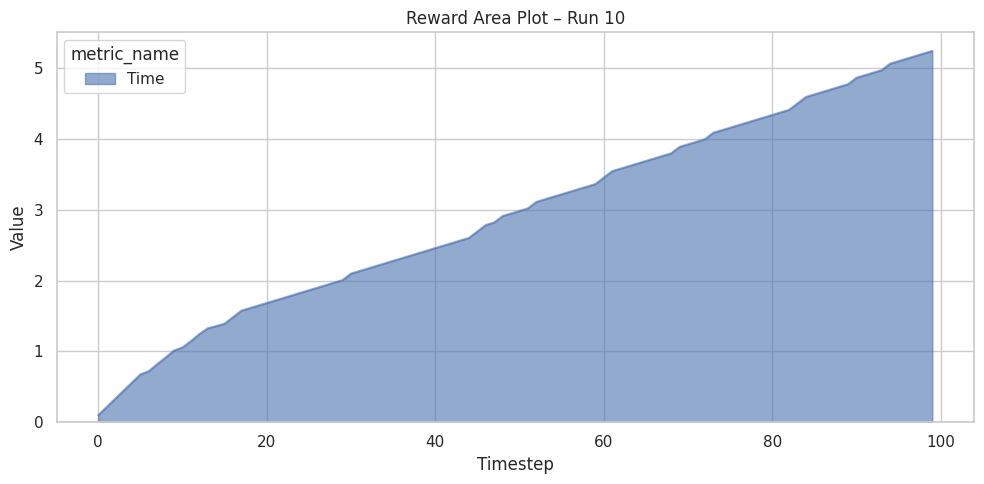

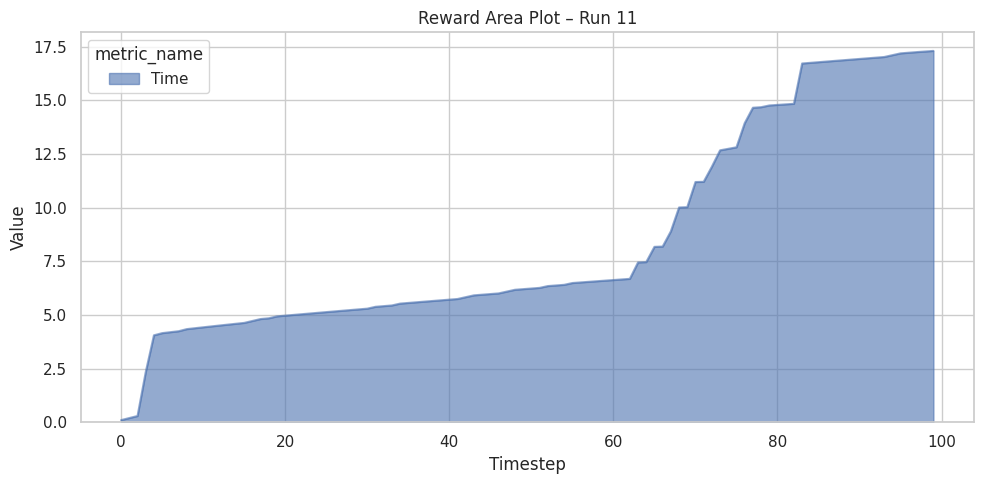

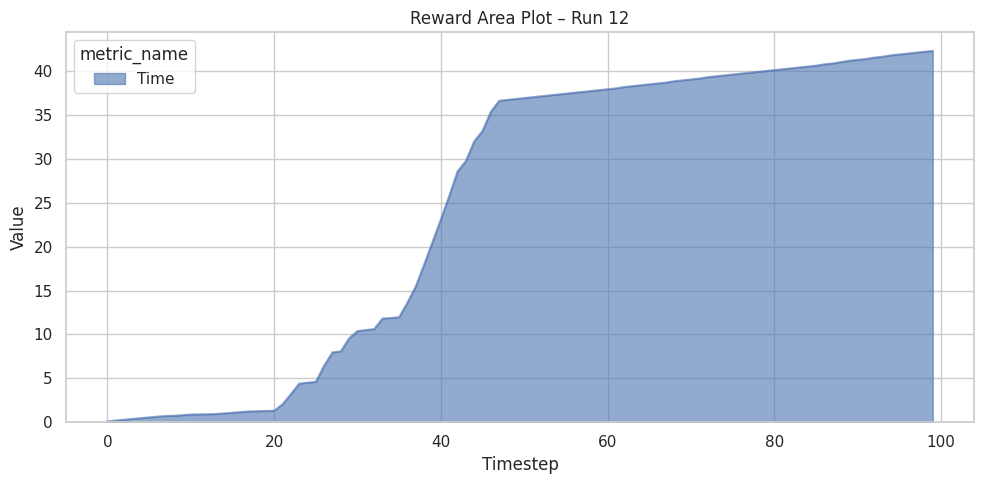

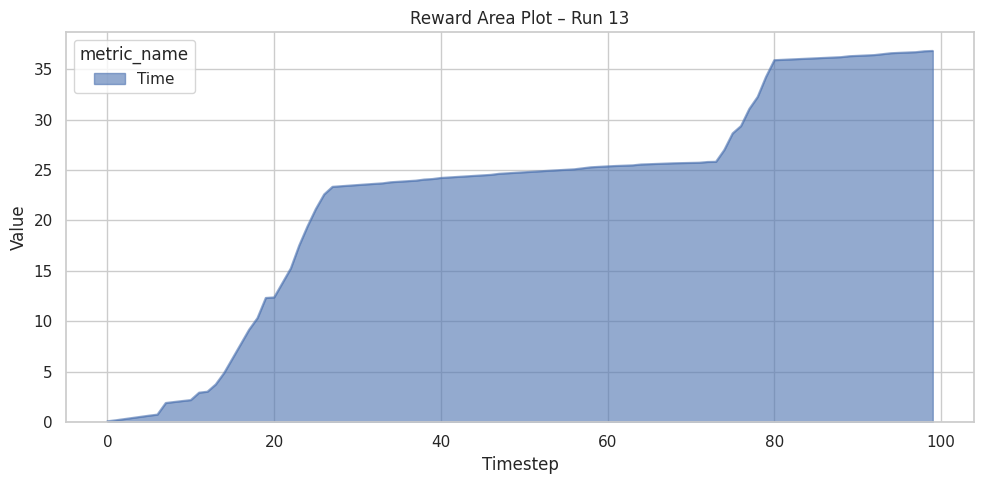

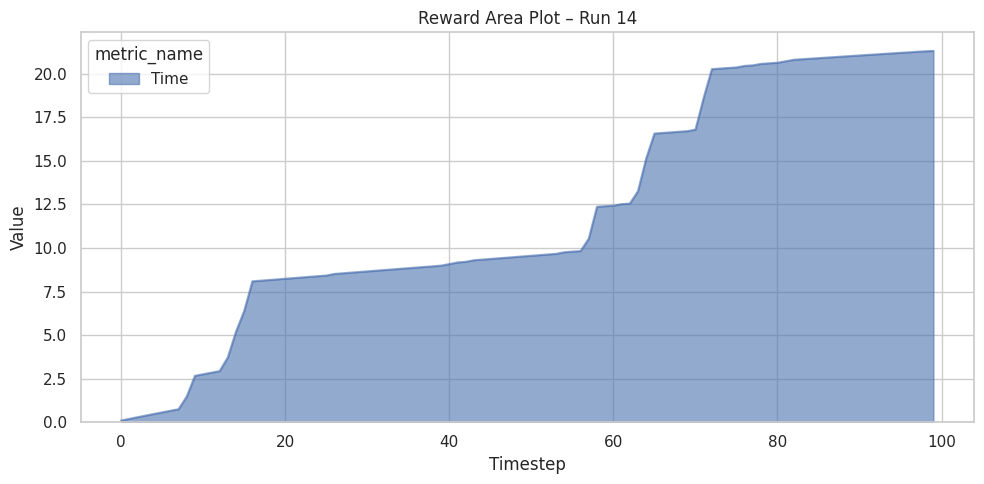

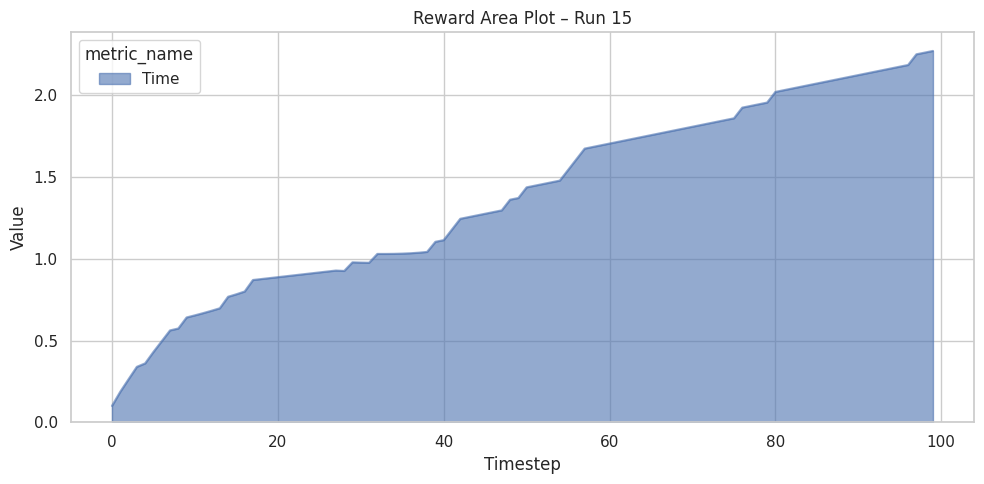

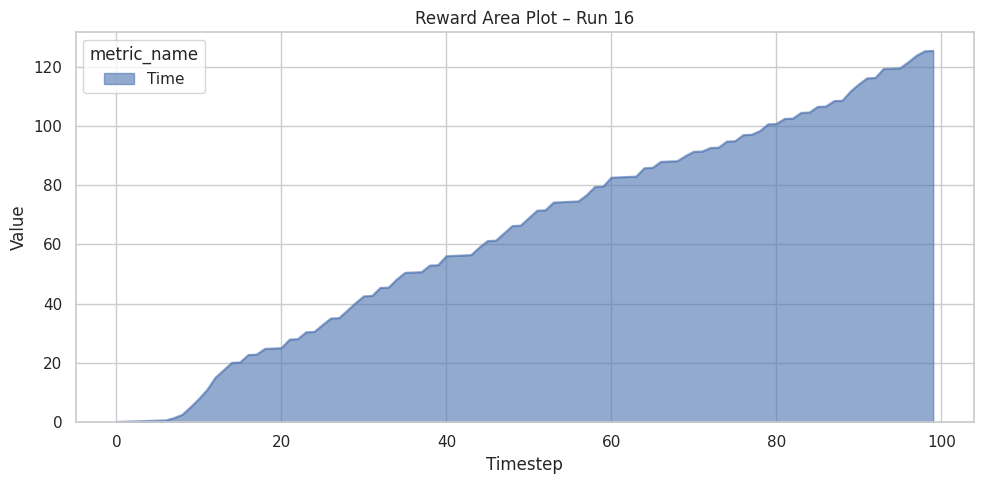

ValueError: When stacked is True, each column must be either all positive or all negative. Column 'Time' contains both positive and negative values

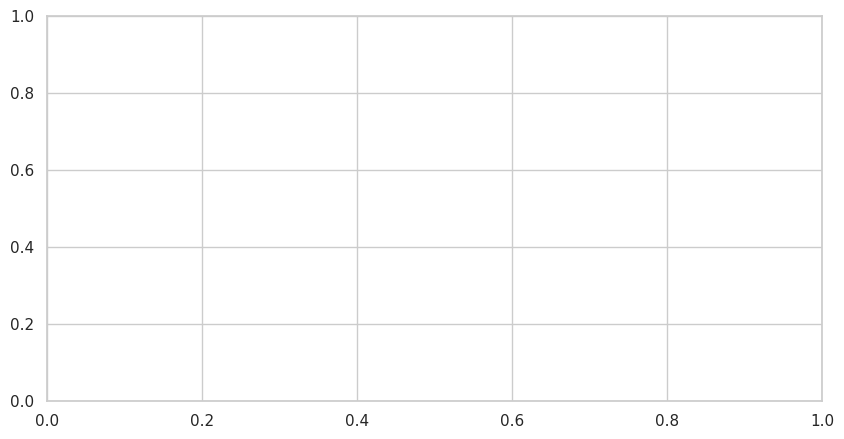

In [10]:
def plot_area_by_category(df, category_name):
    area_df = df[df['metric_category'] == category_name]
    pivoted = area_df.pivot_table(index=['timestep', 'run_id'], 
                                  columns='metric_name', 
                                  values='value').reset_index()

    for run_id in pivoted['run_id'].unique():
        run_df = pivoted[pivoted['run_id'] == run_id].set_index('timestep')
        run_df[run_df.columns.difference(['run_id'])].plot.area(
            figsize=(10, 5), alpha=0.6, title=f'{category_name.title()} Area Plot – Run {run_id}')
        plt.ylabel('Value')
        plt.xlabel('Timestep')
        plt.tight_layout()
        plt.show()

plot_area_by_category(df_long, 'reward')

In [ ]:
def heatmap_final_summary(df):
    summary = df.groupby(['run_id', 'metric_category', 'metric_name']) \
                .tail(1).pivot_table(index='run_id', 
                                     columns=['metric_category', 'metric_name'], 
                                     values='value')

    # Normalize each metric column (min-max scaling)
    normalized = (summary - summary.min()) / (summary.max() - summary.min())

    plt.figure(figsize=(15, 6))
    sns.heatmap(normalized, cmap='viridis', annot=False, cbar_kws={"label": "Normalized Value"})
    plt.title("Final Metric Summary — All Runs (Normalized)")
    plt.ylabel("Run ID")
    plt.xlabel("Metric")
    plt.tight_layout()
    plt.show()



heatmap_final_summary(df_long)